In [1]:
# Cell 1: 라이브러리 및 설정
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer # 필요시 기본 결측치 처리 (이제 사용 안 함)
# from sklearn.ensemble import RandomForestRegressor # HB 결측치 처리용 (이제 사용 안 함)
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 스케일러 저장용
import streamlit as st # GUI용 (Cell 12에서만 사용)
import os # GUI용 파일 경로 확인

# 데이터 경로 정의 (파일명 확인 및 수정)
data_path = "/Users/yeojoon/Documents/PyWorkspace_CreativeDesign/TrainSet0507_NoDuplicatesHV.xlsx" #TrainSet0507_NoDuplicates

# 장치 설정 (가능하면 GPU/MPS, 아니면 CPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"사용 장치: {device}")

# 재현성을 위한 랜덤 시드 설정
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
elif device == 'mps':
     pass

print("라이브러리 임포트 및 설정 완료.")

사용 장치: mps
라이브러리 임포트 및 설정 완료.


In [2]:
# Cell 2: 데이터 로딩 및 초기 검사

try:
    # 'Tensile' 시트 로드
    df_tensile = pd.read_excel(data_path, sheet_name='Tensile', header=0)
    print("--- Tensile 시트 ---")
    print(f"형태: {df_tensile.shape}")
    print("\n컬럼:", df_tensile.columns.tolist())
    print("\n처음 5행:\n", df_tensile.head())
    print("\n데이터 타입:\n", df_tensile.dtypes)
    print("\n결측치 요약:\n", df_tensile.isnull().sum())

except FileNotFoundError:
    print(f"오류: {data_path}에서 파일을 찾을 수 없습니다")
except Exception as e:
    print(f"데이터 로딩 중 오류 발생: {e}")

# 필요한 컬럼명 확인 (주석)
# E: 'E'
# YS: 'YS'
# TS: 'TS'
# HB: 'HB'
# HV: 'HV'
# sf: 'sf' (sigma_f')
# b: 'b'
# ef: 'ef' (epsilon_f')
# c: 'c'


# np_col = "n'" # 선택사항
# kp_col = "K' (MPa)" # 선택사항


--- Tensile 시트 ---
형태: (934, 19)

컬럼: ['Material', 'HeatTreatment', 'E', 'YS', 'TS', 'EL', 'RA', 'K', 'n', 'HV', 'HB', 'sy', 'np', 'Kp', 'sf', 'b', 'ef', 'c', '특이사항']

처음 5행:
   Material HeatTreatment      E   YS     TS    EL   RA      K      n  HV   HB  \
0   0.6040           NaN  140.0  420  570.0   NaN  NaN  902.0  0.130 NaN  NaN   
1   0.7040           NaN  165.0  323  470.0  17.3  NaN  514.0  0.076 NaN  NaN   
2   0.7060           NaN  158.0  382  632.0     7  NaN  507.0  0.043 NaN  NaN   
3   0.7060           NaN  175.0  480  738.0   4.4  NaN    NaN    NaN NaN  NaN   
4   0.8155           NaN  155.0  389  600.0     5  NaN  582.0  0.073 NaN  NaN   

   sy     np    Kp   sf      b      ef      c                    특이사항  
0 NaN  0.153  1012  646 -0.078  0.0353 -0.451                     NaN  
1 NaN  0.065   677  851 -0.075  9.7123 -1.016                     NaN  
2 NaN  0.076   750  720 -0.058  0.7236 -0.782  C 3.52 Si 2.69 Mn 0.53  
3 NaN  0.103   936  805 -0.067  0.2314 -0.652    

In [3]:
# Cell 3: 컬럼 이름 변경 및 타입 변환

# --- 컬럼 이름 매핑 정의 (실제 파일 컬럼명 기준) ---
column_mapping = {
    'E': 'E_GPa',
    'YS': 'YS_MPa',
    'TS': 'TS_MPa',
    'HB': 'HB',
    'HV': 'HV',
    "sf": 'spf_MPa',
    'b': 'b',
    "ef": 'epf',
    'c': 'c',
    # 사용할 경우 선택적 컬럼 추가
    # "n'": 'np',
    # "K' (MPa)": 'Kp_MPa',
    # 'Material Name', 'RA (%)' 등과 같은 다른 관련 컬럼 추가
    #'RA': 'RA_percent' # RA가 존재하고 필요한 경우 예시
}

# 사용할 컬럼만 선택 및 이름 변경
required_cols = list(column_mapping.keys())
available_cols = [col for col in required_cols if col in df_tensile.columns]
missing_cols = [col for col in required_cols if col not in available_cols]

print(f"\n사용 가능한 컬럼: {available_cols}")
if missing_cols:
    print(f"경고: 다음 컬럼이 데이터에 없습니다: {missing_cols}. 해당 컬럼 없이 진행합니다.")
    # 필수 컬럼 누락 시 에러 처리 또는 중지 로직 추가 가능

# 사용 가능한 컬럼만으로 매핑 재생성
column_mapping_available = {k: v for k, v in column_mapping.items() if k in available_cols}

df = df_tensile[available_cols].copy()
df.rename(columns=column_mapping_available, inplace=True)

hv_col_exists = 'HV' in df.columns

# 숫자형 변환 (오류는 NaN)
numeric_cols_base = ['E_GPa', 'YS_MPa', 'TS_MPa', 'HB', 'spf_MPa', 'b', 'epf', 'c']
numeric_cols = [col for col in numeric_cols_base if col in df.columns] # 존재하는 컬럼만 대상으로 함
if hv_col_exists:
    numeric_cols.append('HV')

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n이름 변경 및 숫자 변환 후 DataFrame:")
print(df.head())
print("\n데이터 타입:\n", df.dtypes)
print("\n강제 변환 후 결측치 요약:\n", df.isnull().sum())

# E 단위 변환 (GPa -> MPa)
if 'E_GPa' in df.columns:
    df['E_MPa'] = df['E_GPa'] * 1000
    df.drop(columns=['E_GPa'], inplace=True)
    print("\nE를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).")
    # Ensure E_MPa is in numeric_cols if E_GPa was
    if 'E_GPa' in numeric_cols:
        numeric_cols.remove('E_GPa')
        if 'E_MPa' not in numeric_cols:
             numeric_cols.append('E_MPa')


# 최종 특성 및 타겟 컬럼 이름 정의 (HB는 Cell 4에서 처리 후 추가)
feature_cols_base = ['E_MPa', 'YS_MPa', 'TS_MPa']
feature_cols = [col for col in feature_cols_base if col in df.columns] # 존재하는 특성만 사용
target_cols_base = ['spf_MPa', 'b', 'epf', 'c']
target_cols = [col for col in target_cols_base if col in df.columns] # 존재하는 타겟만 사용

# 타겟 변수 누락 행 제거
if not target_cols:
     print("오류: 타겟 변수가 하나도 없습니다. 학습을 진행할 수 없습니다.")
else:
    initial_rows = len(df)
    df.dropna(subset=target_cols, inplace=True)
    print(f"\n타겟 값({target_cols})이 누락된 {initial_rows - len(df)}개 행을 삭제했습니다.")
    print(f"남은 행: {len(df)}")


사용 가능한 컬럼: ['E', 'YS', 'TS', 'HB', 'HV', 'sf', 'b', 'ef', 'c']

이름 변경 및 숫자 변환 후 DataFrame:
   E_GPa  YS_MPa  TS_MPa  HB  HV  spf_MPa      b     epf      c
0  140.0   420.0   570.0 NaN NaN    646.0 -0.078  0.0353 -0.451
1  165.0   323.0   470.0 NaN NaN    851.0 -0.075  9.7123 -1.016
2  158.0   382.0   632.0 NaN NaN    720.0 -0.058  0.7236 -0.782
3  175.0   480.0   738.0 NaN NaN    805.0 -0.067  0.2314 -0.652
4  155.0   389.0   600.0 NaN NaN    712.0 -0.073  0.1460 -0.573

데이터 타입:
 E_GPa      float64
YS_MPa     float64
TS_MPa     float64
HB         float64
HV         float64
spf_MPa    float64
b          float64
epf        float64
c          float64
dtype: object

강제 변환 후 결측치 요약:
 E_GPa       17
YS_MPa      40
TS_MPa      29
HB         259
HV         889
spf_MPa     12
b            5
epf         13
c            9
dtype: int64

E를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).

타겟 값(['spf_MPa', 'b', 'epf', 'c'])이 누락된 16개 행을 삭제했습니다.
남은 행: 918


In [4]:
# Cell 4: HB/HV 처리 (수정됨 - ML/Median 대체 제거, HV 변환 우선)

hb_col_name = 'HB' # 원본 HB 컬럼명 (매핑 후 이름)
hv_col_name = 'HV' # 원본 HV 컬럼명 (매핑 후 이름)
hb_processed_col = 'HB_processed' # 새로 생성할 처리된 HB 컬럼

if hb_col_name not in df.columns:
    print(f"경고: HB 컬럼('{hb_col_name}')이 없습니다. HB 특성을 사용할 수 없습니다.")
    # HB 컬럼이 아예 없으면 hb_processed 생성 불가 -> 이후 로직에서 HB 사용 제외 필요
    hb_available = False
else:
    hb_available = True
    df[hb_processed_col] = df[hb_col_name].copy() # 기본값: 원본 HB 사용

    # HB가 NaN 이고 HV가 있는 경우, HV -> HB 변환
    if hv_col_exists:
        conversion_mask = df[hb_processed_col].isnull() & df[hv_col_name].notnull()
        # 변환 (필요수정)
        df.loc[conversion_mask, hb_processed_col] = 0.95 * df.loc[conversion_mask, hv_col_name]
        print(f"Imputed {conversion_mask.sum()} missing HB values using HV conversion.")
    else:
        print("HV column not found. Skipping HV->HB conversion.")

    # HB_processed 컬럼을 feature_cols 에 추가
    feature_cols.append(hb_processed_col)
    print(f"\n'{hb_processed_col}' 컬럼을 특성에 추가했습니다.")

    # HB_processed 가 여전히 NaN 인 행은 HB/HV 모두 없는 경우 -> 분석에서 제외
    initial_rows_before_hb_drop = len(df)
    df.dropna(subset=[hb_processed_col], inplace=True)
    dropped_for_hb = initial_rows_before_hb_drop - len(df)
    if dropped_for_hb > 0:
        print(f"\nDropped {dropped_for_hb} rows where both HB and HV were missing or invalid.")


# 최종 특성 컬럼에서 결측치가 있는 행 제거 (E, YS, TS 등 포함)
initial_rows_before_feature_drop = len(df)
df.dropna(subset=feature_cols, inplace=True)
dropped_for_features = initial_rows_before_feature_drop - len(df)
if dropped_for_features > 0:
     print(f"Dropped {dropped_for_features} rows with missing values in features: {feature_cols}.")

print(f"\nFinal Feature Columns: {feature_cols}")
print(f"Target Columns: {target_cols}")
print("\nDataFrame after HB/HV processing and final NA drop:")
print(df[feature_cols + target_cols].head())
print("\nMissing values check for final features and targets:")
print(df[feature_cols + target_cols].isnull().sum())
print(f"Final number of samples for training/testing: {len(df)}")

Imputed 39 missing HB values using HV conversion.

'HB_processed' 컬럼을 특성에 추가했습니다.

Dropped 213 rows where both HB and HV were missing or invalid.
Dropped 23 rows with missing values in features: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed'].

Final Feature Columns: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed']
Target Columns: ['spf_MPa', 'b', 'epf', 'c']

DataFrame after HB/HV processing and final NA drop:
       E_MPa  YS_MPa  TS_MPa  HB_processed  spf_MPa      b     epf      c
28  206000.0   540.0   790.0       2280.00    987.0 -0.083  0.9672 -0.712
31  181000.0   149.0   411.0        168.15    575.0 -0.097  0.1141 -0.371
32  177000.0   147.0   413.0        190.00    517.0 -0.082  0.1273 -0.379
33  158000.0   130.0   389.0        208.05    479.0 -0.068  0.0817 -0.370
34  204000.0   222.0   569.0        227.05   1655.0 -0.134  0.0667 -0.322

Missing values check for final features and targets:
E_MPa           0
YS_MPa          0
TS_MPa          0
HB_processed    0
spf_MPa         0
b 


--- Exploratory Data Analysis ---

Descriptive Statistics (Features and Targets):
               E_MPa       YS_MPa       TS_MPa  HB_processed      spf_MPa  \
count     682.000000   682.000000   682.000000    682.000000   682.000000   
mean   204432.760997   738.860850   977.870352    272.623534  1447.090264   
std      9441.368531   442.427281   448.443995    136.786215   632.349316   
min    158000.000000   130.000000   318.000000     80.000000   391.000000   
25%    200000.000000   413.250000   666.000000    189.000000  1043.025000   
50%    206000.000000   622.000000   898.000000    252.000000  1255.000000   
75%    210000.000000   936.250000  1146.750000    324.275000  1694.000000   
max    249000.000000  2536.000000  2950.000000   2280.000000  5813.000000   

                b         epf           c  
count  682.000000  682.000000  682.000000  
mean    -0.094058    0.828002   -0.602977  
std      0.029741    1.450465    0.137286  
min     -0.253000    0.000570   -1.082000  
25%

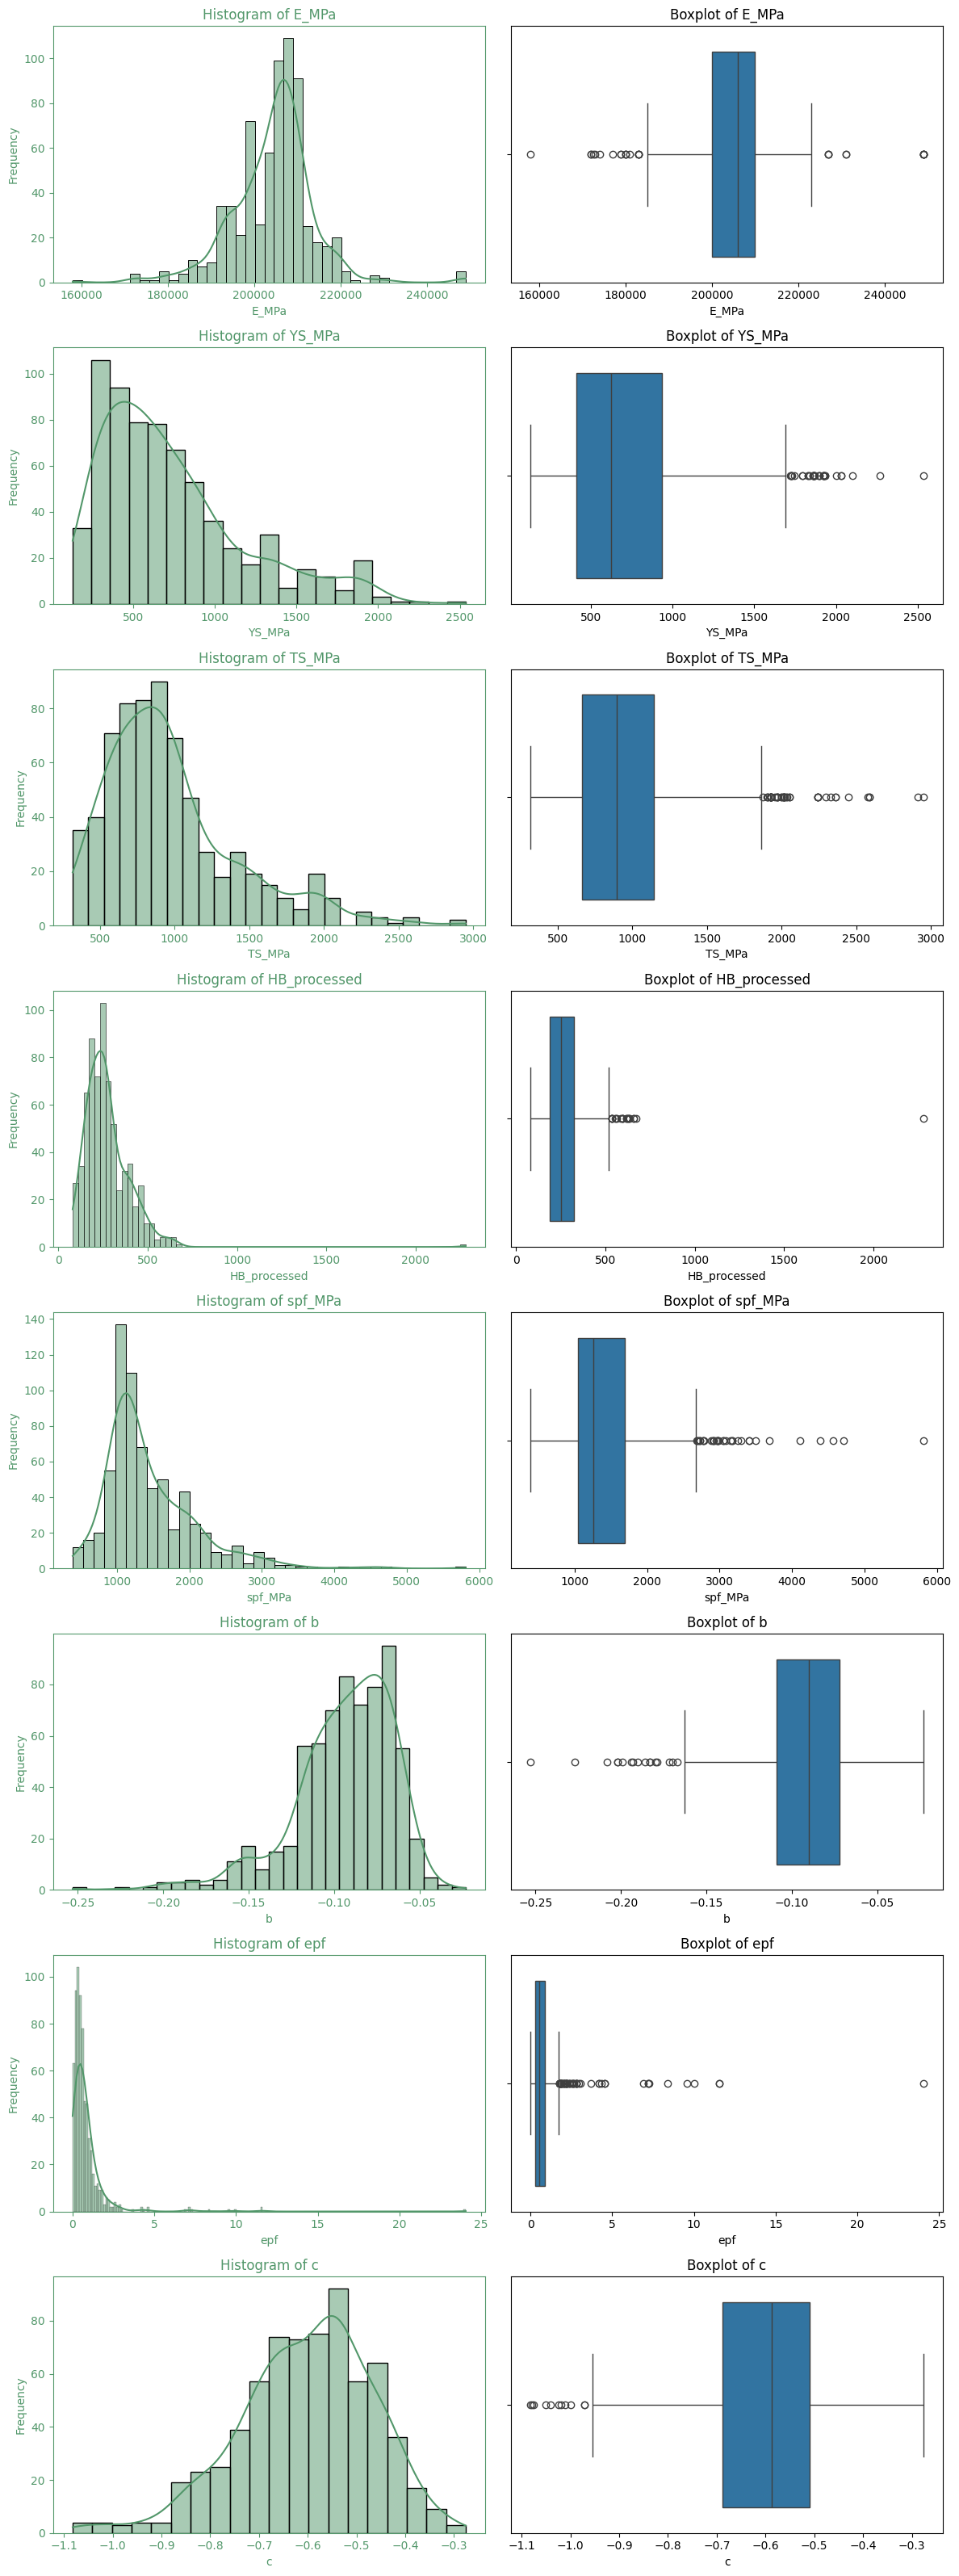

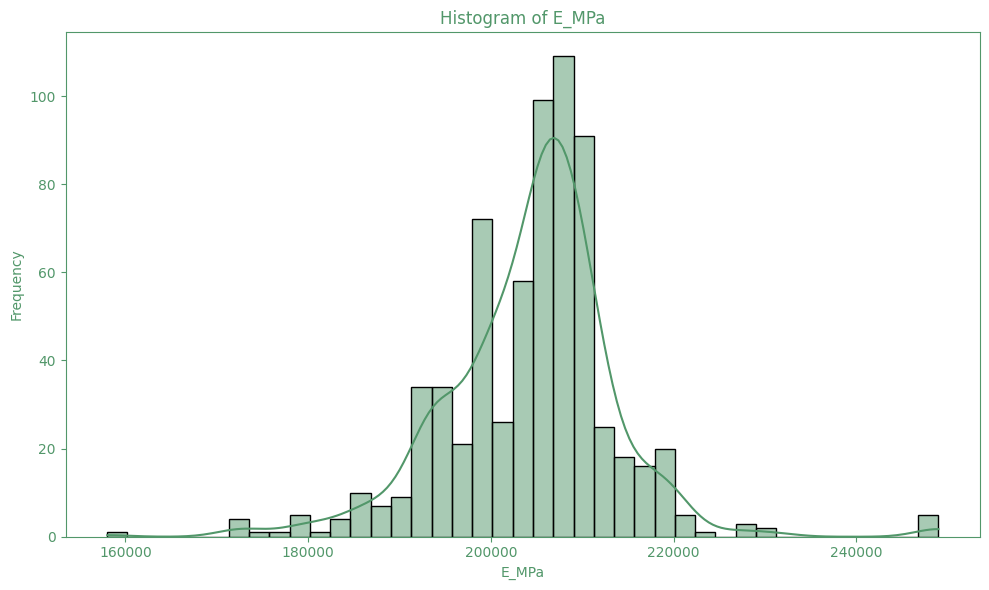


Calculating and Plotting Correlation Matrix...


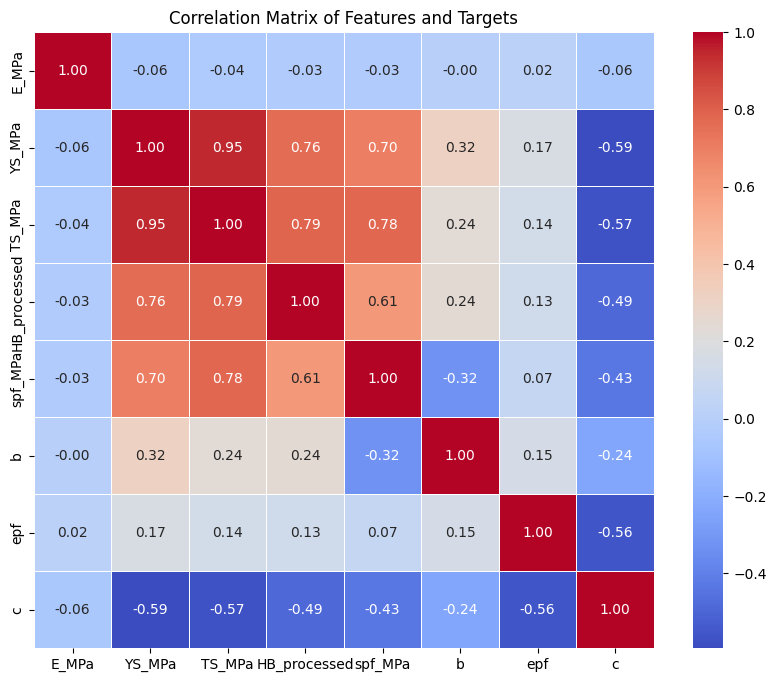


Analysis of target parameters:
Range of 'b': -0.253 -0.023
Range of 'c': -1.082 -0.276
Percentage of non-negative 'b': 0.00%
Percentage of non-negative 'c': 0.00%
Percentage where spf_MPa <= TS_MPa: 2.05%

--- Analysis of Log-Transformed epf ---

Descriptive Statistics (Log-Transformed epf):
count    682.000000
mean       0.497764
std        0.381052
min        0.000570
25%        0.258511
50%        0.416735
75%        0.634451
max        3.220834
Name: epf, dtype: float64


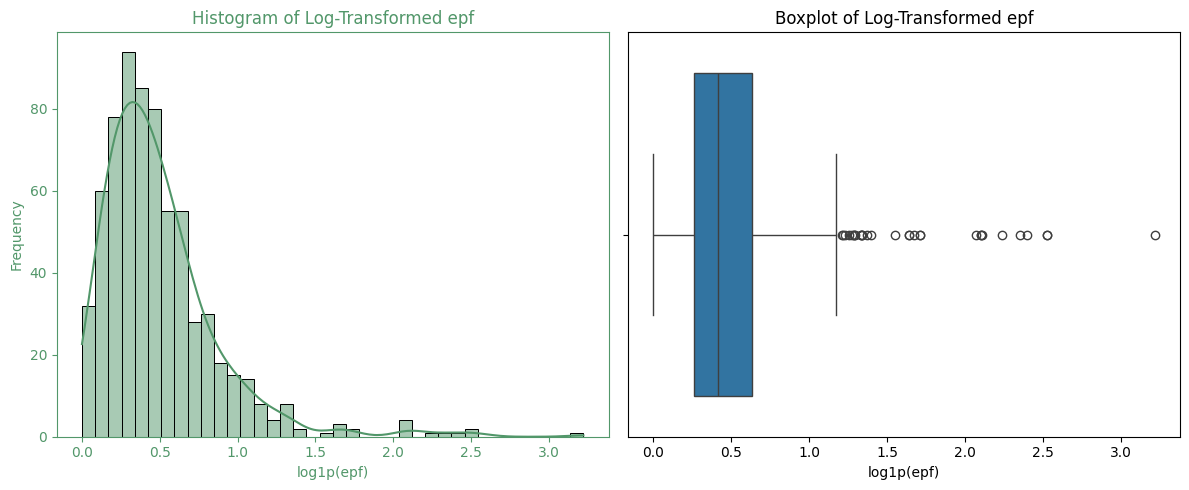

In [5]:
# Cell 5: 탐색적 데이터 분석 (EDA) - 큰 변경 없음, HB_imputed_flag_col 관련 부분 제거

print("\n--- Exploratory Data Analysis ---")

if len(df) > 0: # 데이터가 남아있는 경우에만 EDA 수행
    # 1. Descriptive Statistics
    print("\nDescriptive Statistics (Features and Targets):")
    print(df[feature_cols + target_cols].describe())

    # 2. Distributions
    print("\nPlotting Distributions...")
    n_features = len(feature_cols)
    n_targets = len(target_cols)
    # figure 크기 동적 조절
    fig_height = max(4 * (n_features + n_targets), 12)
    fig, axes = plt.subplots(n_features + n_targets, 2, figsize=(12, fig_height), facecolor='none')

    if n_features + n_targets == 1: # 축 객체가 1차원 배열인 경우 처리
        axes = np.array([axes])
        
    # custom color 정의
    custom_color = (82/255, 151/255, 106/255)  # RGB 값

    for i, col in enumerate(feature_cols + target_cols):
        if col in df.columns: # 컬럼 존재 확인
             # 1열(히스토그램)에 custom color 적용
             sns.histplot(df[col], kde=True, ax=axes[i, 0], color=custom_color)
             axes[i, 0].set_title(f'Histogram of {col}', color=custom_color)
             axes[i, 0].set_xlabel(col, color=custom_color)
             axes[i, 0].set_ylabel('Frequency', color=custom_color)
             axes[i, 0].tick_params(axis='x', colors=custom_color)
             axes[i, 0].tick_params(axis='y', colors=custom_color)
             axes[i, 0].spines['bottom'].set_color(custom_color)
             axes[i, 0].spines['top'].set_color(custom_color)
             axes[i, 0].spines['left'].set_color(custom_color)
             axes[i, 0].spines['right'].set_color(custom_color)
             axes[i, 0].set_facecolor('none')  # 배경 투명하게 설정
             
             # 2열(박스플롯)은 기본 색상 유지
             sns.boxplot(x=df[col], ax=axes[i, 1])
             axes[i, 1].set_title(f'Boxplot of {col}')
             axes[i, 1].set_facecolor('none')  # 배경 투명하게 설정

    plt.tight_layout()
    plt.show()
    
    # custom color 그래프 추가 (첫 번째 컬럼만)
    if len(feature_cols) > 0:
        custom_color = (82/255, 151/255, 106/255)  # RGB 값
        first_col = feature_cols[0]
        
        fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')  # 배경 투명하게 설정
        sns.histplot(df[first_col], kde=True, ax=ax, color=custom_color)
        
        # 모든 요소를 custom color로 설정
        ax.set_title(f'Histogram of {first_col}', color=custom_color)
        ax.set_xlabel(first_col, color=custom_color)
        ax.set_ylabel('Frequency', color=custom_color)
        ax.tick_params(axis='x', colors=custom_color)
        ax.tick_params(axis='y', colors=custom_color)
        ax.spines['bottom'].set_color(custom_color)
        ax.spines['top'].set_color(custom_color)
        ax.spines['left'].set_color(custom_color)
        ax.spines['right'].set_color(custom_color)
        ax.set_facecolor('none')  # 배경 투명하게 설정
        
        plt.tight_layout()
        plt.show()

    # 3. Correlation Matrix
    print("\nCalculating and Plotting Correlation Matrix...")
    # 상관관계 계산 전, 수치형 데이터만 있는지 확인
    numeric_df_for_corr = df[feature_cols + target_cols].select_dtypes(include=np.number)
    if not numeric_df_for_corr.empty:
        correlation_matrix = numeric_df_for_corr.corr()
        plt.figure(figsize=(10, 8), facecolor='none')  # 배경 투명하게 설정
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Features and Targets')
        plt.gca().set_facecolor('none')  # 히트맵 배경 투명하게 설정
        plt.show()
    else:
        print("No numeric columns found for correlation analysis.")


    # 4. Pair Plots (optional)
    # ...

    # 5. Analysis of Target Parameters (Physical Plausibility)
    print("\nAnalysis of target parameters:")
    if 'b' in df.columns: print("Range of 'b':", df['b'].min(), df['b'].max())
    if 'c' in df.columns: print("Range of 'c':", df['c'].min(), df['c'].max())
    if 'b' in df.columns: print(f"Percentage of non-negative 'b': { (df['b'] >= 0).mean() * 100:.2f}%")
    if 'c' in df.columns: print(f"Percentage of non-negative 'c': { (df['c'] >= 0).mean() * 100:.2f}%")
    if 'spf_MPa' in df.columns and 'TS_MPa' in df.columns:
         print(f"Percentage where spf_MPa <= TS_MPa: { (df['spf_MPa'] <= df['TS_MPa']).mean() * 100:.2f}%")

    # HB imputation status 비교 제거 (HB_imputed_flag_col 없음)
    
    print("\n--- Analysis of Log-Transformed epf ---")
    if 'epf' in target_cols:
        epf_original_values = df['epf'].copy() # 원본 epf 값 사용 (결측치 제거 후)
        epf_log_transformed = np.log1p(np.maximum(epf_original_values, 1e-10))

        print("\nDescriptive Statistics (Log-Transformed epf):")
        print(pd.Series(epf_log_transformed).describe())

        custom_color = (82/255, 151/255, 106/255)  # RGB 값
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), facecolor='none')
        
        # 히스토그램에 custom color 적용
        sns.histplot(epf_log_transformed, kde=True, ax=axes[0], color=custom_color)
        axes[0].set_title('Histogram of Log-Transformed epf', color=custom_color)
        axes[0].set_xlabel('log1p(epf)', color=custom_color)
        axes[0].set_ylabel('Frequency', color=custom_color)
        axes[0].tick_params(axis='x', colors=custom_color)
        axes[0].tick_params(axis='y', colors=custom_color)
        axes[0].spines['bottom'].set_color(custom_color)
        axes[0].spines['top'].set_color(custom_color)
        axes[0].spines['left'].set_color(custom_color)
        axes[0].spines['right'].set_color(custom_color)
        axes[0].set_facecolor('none')  # 배경 투명하게 설정

        # 박스플롯은 기본 색상 유지
        sns.boxplot(x=epf_log_transformed, ax=axes[1])
        axes[1].set_title('Boxplot of Log-Transformed epf')
        axes[1].set_xlabel('log1p(epf)')
        axes[1].set_facecolor('none')  # 배경 투명하게 설정
        
        plt.tight_layout()
        plt.show()
    else:
        print("epf column not found in target_cols for log-transformed analysis.")

else:
    print("\nNo data available for EDA after preprocessing.")


In [6]:
# Cell 6: 데이터 준비 (PyTorch용) - df 사용 확인

print("\n--- Preparing Data for PyTorch (Tensile Model) ---")

if len(df) > 0:
    # Select final features (X) and targets (y) for tensile model
    X = df[feature_cols].values
    y = df[target_cols].values
    # E_MPa 컬럼이 있는지 확인 후 추출
    if 'E_MPa' in df.columns:
        E_for_loss = df['E_MPa'].values
        print(f"E for loss shape: {E_for_loss.shape}")
    else:
        print("Warning: E_MPa column not found. Cannot extract E for physics loss calculation.")
        E_for_loss = np.zeros(len(df)) # 임시값 또는 다른 처리 필요

    print(f"Features shape (X): {X.shape}")
    print(f"Targets shape (y): {y.shape}")

    # 1. Train-Validation-Test Split
    X_train_val, X_test, y_train_val, y_test, E_train_val, E_test = train_test_split(
        X, y, E_for_loss, test_size=0.15, random_state=seed)
    X_train, X_val, y_train, y_val, E_train, E_val = train_test_split(
        X_train_val, y_train_val, E_train_val, test_size=0.1765, random_state=seed) # 0.1765 * 0.85 ≈ 0.15

    print(f"Train set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # 2. Scaling
    # scaler_X는 기존과 동일
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    # --- 개별 타겟 스케일링 및 epf 로그 변환 ---
    target_cols_idx = {name: idx for idx, name in enumerate(target_cols)}
    epf_idx = target_cols_idx.get('epf', -1)

    y_train_transformed = y_train.copy()
    y_val_transformed = y_val.copy()
    y_test_transformed = y_test.copy()

    if epf_idx != -1:
        print(f"epf 컬럼 (인덱스 {epf_idx})에 np.log1p 변환을 적용합니다.")
        # 0 또는 음수 값 방지를 위해 np.maximum 사용
        y_train_transformed[:, epf_idx] = np.log1p(np.maximum(y_train_transformed[:, epf_idx], 1e-10))
        y_val_transformed[:, epf_idx] = np.log1p(np.maximum(y_val_transformed[:, epf_idx], 1e-10))
        y_test_transformed[:, epf_idx] = np.log1p(np.maximum(y_test_transformed[:, epf_idx], 1e-10))
        
        # 로그 변환 적용 확인
        print("\n--- 로그 변환 적용 확인 ---")
        print(f"Train 데이터 epf 로그 변환 전/후 (처음 3개 샘플):")
        for i in range(min(3, len(y_train))):
            print(f"  샘플 {i+1}: {y_train[i, epf_idx]:.6f} -> {y_train_transformed[i, epf_idx]:.6f}")
        
        print(f"\nValidation 데이터 epf 로그 변환 전/후 (처음 3개 샘플):")
        for i in range(min(3, len(y_val))):
            print(f"  샘플 {i+1}: {y_val[i, epf_idx]:.6f} -> {y_val_transformed[i, epf_idx]:.6f}")
            
        print(f"\nTest 데이터 epf 로그 변환 전/후 (처음 3개 샘플):")
        for i in range(min(3, len(y_test))):
            print(f"  샘플 {i+1}: {y_test[i, epf_idx]:.6f} -> {y_test_transformed[i, epf_idx]:.6f}")
        
        # 통계적 확인
        print("\n로그 변환 전/후 통계 비교:")
        print(f"Train 데이터 - 원본 epf: 평균={np.mean(y_train[:, epf_idx]):.4f}, 표준편차={np.std(y_train[:, epf_idx]):.4f}")
        print(f"Train 데이터 - 변환 epf: 평균={np.mean(y_train_transformed[:, epf_idx]):.4f}, 표준편차={np.std(y_train_transformed[:, epf_idx]):.4f}")
        
        print(f"  epf 로그 변환 전/후 (train 예시): [{y_train[0, epf_idx]:.6f}] -> [{y_train_transformed[0, epf_idx]:.6f}]")

    scalers_y = {} # 각 타겟별 스케일러 저장용 딕셔너리
    y_train_scaled = np.zeros_like(y_train_transformed)
    y_val_scaled = np.zeros_like(y_val_transformed)
    y_test_scaled = np.zeros_like(y_test_transformed)

    for i, col_name in enumerate(target_cols):
        scalers_y[col_name] = StandardScaler()
        print(f"Target '{col_name}' will be scaled using StandardScaler.")
            
        y_train_scaled[:, i] = scalers_y[col_name].fit_transform(y_train_transformed[:, i].reshape(-1, 1)).flatten()
        y_val_scaled[:, i] = scalers_y[col_name].transform(y_val_transformed[:, i].reshape(-1, 1)).flatten()
        y_test_scaled[:, i] = scalers_y[col_name].transform(y_test_transformed[:, i].reshape(-1, 1)).flatten()
        
    # 개별 스케일러 적용 확인
    print("\n--- 개별 스케일러 적용 확인 ---")
    for i, col_name in enumerate(target_cols):
        print(f"\n{col_name} 스케일링 확인 ({type(scalers_y[col_name]).__name__} 사용):") # 사용된 스케일러 타입 명시
        print(f"  변환된 데이터 (스케일링 전) - 평균: {np.mean(y_train_transformed[:, i]):.6f}, 표준편차: {np.std(y_train_transformed[:, i]):.6f}")
        print(f"  스케일링된 데이터 - 평균: {np.mean(y_train_scaled[:, i]):.6f}, 표준편차: {np.std(y_train_scaled[:, i]):.6f}")
        
        print(f"  샘플 데이터 비교 (처음 3개):")
        for j in range(min(3, len(y_train))):
            print(f"    샘플 {j+1}: {y_train_transformed[j, i]:.6f} -> {y_train_scaled[j, i]:.6f}")
            
        if col_name == 'epf':
            print(f"  epf 로그변환 후 {type(scalers_y[col_name]).__name__} 스케일링 확인:") # 스케일러 타입 명시
            orig_epf = y_train[0, i]
            log_epf = y_train_transformed[0, i]
            scaled_epf = y_train_scaled[0, i]
            print(f"    원본 -> 로그변환 -> 스케일링: {orig_epf:.6f} -> {log_epf:.6f} -> {scaled_epf:.6f}")
            
            direct_scaled = scalers_y['epf'].transform(np.array([log_epf]).reshape(-1, 1))[0][0]
            print(f"    스케일러 직접 적용 결과: {direct_scaled:.6f} (스케일링된 값과 일치해야 함)")

    # 역변환 함수 정의 (개별 스케일러 및 epf 로그 역변환 고려)
    def inverse_transform_targets(y_scaled_data, scalers_y_dict, target_cols_list):
        # y_scaled_data가 1차원 배열일 경우 (예: 단일 샘플 예측) 2차원으로 변환
        if y_scaled_data.ndim == 1:
            y_scaled_data = y_scaled_data.reshape(1, -1)
            
        y_transformed_individually = np.zeros_like(y_scaled_data)
        for i, col_name in enumerate(target_cols_list):
            # 각 컬럼에 해당하는 스케일러로 역변환
            y_transformed_individually[:, i] = scalers_y_dict[col_name].inverse_transform(y_scaled_data[:, i].reshape(-1, 1)).flatten()
        
        y_orig_scale = y_transformed_individually.copy()
        
        current_epf_idx = -1
        if 'epf' in target_cols_list:
            current_epf_idx = target_cols_list.index('epf')
            
        if current_epf_idx != -1:
            # expm1을 사용하여 로그 변환 역변환
            y_orig_scale[:, current_epf_idx] = np.expm1(y_transformed_individually[:, current_epf_idx])
            print(f"epf (index {current_epf_idx}) 역변환 (np.expm1) applied.")
        
        # 만약 원래 y_scaled_data가 1차원이었다면, 결과도 1차원으로 반환
        if y_scaled_data.shape[0] == 1 and y_orig_scale.shape[0] == 1:
             return y_orig_scale.flatten()
        return y_orig_scale

    joblib.dump(scaler_X, 'scaler_X.pkl')
    joblib.dump(scalers_y, 'scalers_y.pkl') # 스케일러 딕셔너리 저장
    print("Features scaled. Feature scaler (scaler_X.pkl) and target scalers dictionary (scalers_y.pkl) saved.")

    # 3. Create PyTorch Datasets and DataLoaders
    batch_size = 16

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    E_train_tensor = torch.tensor(E_train, dtype=torch.float32).unsqueeze(1)

    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
    E_val_tensor = torch.tensor(E_val, dtype=torch.float32).unsqueeze(1)

    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32) # 스케일링된 y_test 사용
    E_test_tensor = torch.tensor(E_test, dtype=torch.float32).unsqueeze(1)
    # y_test_orig_tensor는 원본 y_test (로그 변환 전, 스케일링 전) 값을 사용해야 합니다.
    y_test_orig_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor, E_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor, E_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor, E_test_tensor, y_test_orig_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("PyTorch Datasets and DataLoaders created for tensile model.")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")

else:
    print("\nNo data available for PyTorch preparation.")


--- Preparing Data for PyTorch (Tensile Model) ---
E for loss shape: (682,)
Features shape (X): (682, 4)
Targets shape (y): (682, 4)
Train set size: 476
Validation set size: 103
Test set size: 103
epf 컬럼 (인덱스 2)에 np.log1p 변환을 적용합니다.

--- 로그 변환 적용 확인 ---
Train 데이터 epf 로그 변환 전/후 (처음 3개 샘플):
  샘플 1: 0.588600 -> 0.462853
  샘플 2: 0.230000 -> 0.207014
  샘플 3: 0.503000 -> 0.407463

Validation 데이터 epf 로그 변환 전/후 (처음 3개 샘플):
  샘플 1: 0.675000 -> 0.515813
  샘플 2: 0.240000 -> 0.215111
  샘플 3: 0.312000 -> 0.271553

Test 데이터 epf 로그 변환 전/후 (처음 3개 샘플):
  샘플 1: 1.008000 -> 0.697139
  샘플 2: 2.080000 -> 1.124930
  샘플 3: 0.225000 -> 0.202941

로그 변환 전/후 통계 비교:
Train 데이터 - 원본 epf: 평균=0.8065, 표준편차=1.1009
Train 데이터 - 변환 epf: 평균=0.5051, 표준편차=0.3606
  epf 로그 변환 전/후 (train 예시): [0.588600] -> [0.462853]
Target 'spf_MPa' will be scaled using StandardScaler.
Target 'b' will be scaled using StandardScaler.
Target 'epf' will be scaled using StandardScaler.
Target 'c' will be scaled using StandardScaler.

--- 개별 스케일러 

In [7]:
# Cell 7: PINN 모델 정의 (FatiguePINN) - 드롭아웃 추가, [128, 256, 128] 구조

if len(df) > 0:
    class FatiguePINN(nn.Module):
        def __init__(self, input_dim, output_dim, hidden_dims=[128, 256, 128], dropout_p=0.2): 
            super().__init__()
            self.input_dim = input_dim
            self.output_dim = output_dim

            layers = []
            last_dim = input_dim
            for hidden_dim in hidden_dims: # 인자로 받은 hidden_dims를 사용
                layers.append(nn.Linear(last_dim, hidden_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_p))  # 드롭아웃 레이어 추가
                last_dim = hidden_dim
            
            layers.append(nn.Linear(last_dim, output_dim)) # 최종 출력 레이어
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # 모델 인스턴스화
    input_dim = X_train_scaled.shape[1] if 'X_train_scaled' in locals() else 4 
    output_dim = y_train_scaled.shape[1] if 'y_train_scaled' in locals() else 4 
    
    # --- 은닉층 구조 설정 ---
    hidden_dims_target = [128, 256, 128] # 목표하는 은닉층 구조 (3개 층)
    dropout_rate = 0.1  # 드롭아웃 비율 설정
    
    # 모델 생성 시 hidden_dims_target와 dropout_p를 전달합니다.
    model = FatiguePINN(input_dim, output_dim, hidden_dims=hidden_dims_target, dropout_p=dropout_rate).to(device)

    print(f"PINN Model Definition (FatiguePINN with hidden_dims={hidden_dims_target}, dropout_p={dropout_rate}):")
    print(model) 

    # 더미 테스트
    try:
        batch_size_local = batch_size if 'batch_size' in locals() else 16
        dummy_input = torch.randn(batch_size_local, input_dim).to(device)
        dummy_output = model(dummy_input)
        print(f"\nDummy input shape: {dummy_input.shape}")
        print(f"Dummy output shape: {dummy_output.shape}")
    except Exception as e:
        print(f"\nCould not perform dummy test: {e}")
else:
    print("\nSkipping model definition as no data is available.")

PINN Model Definition (FatiguePINN with hidden_dims=[128, 256, 128], dropout_p=0.1):
FatiguePINN(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=4, bias=True)
  )
)

Dummy input shape: torch.Size([16, 4])
Dummy output shape: torch.Size([16, 4])


In [8]:
# Cell 8: 손실 함수 정의 (PINN) - lambda_physics_value 수정

if len(df) > 0:
    def pinn_loss_function(model_outputs_scaled, targets_scaled, E_unscaled,
                           scalers_y_dict, target_cols_list,  # 수정된 부분
                           lambda_physics=0.1, num_physics_points=20, 
                           Nf_min=1e1, Nf_max=1e7, device='cpu'):
        """
        Calculates the combined Data and Physics loss for the Fatigue PINN.
        (Function definition remains the same as provided previously)
        """
        # 1. Data Loss (MSE on scaled parameters)
        data_loss_fn = nn.MSELoss()
        
        data_loss_components = []
        epf_loss_weight = 1.5  # epf에 대한 가중치 (예: 2.0, 3.0, 5.0 등으로 시작하여 튜닝)
                             # 이 값을 조절하며 epf 정확도 변화를 관찰합니다.

        for i, col_name in enumerate(target_cols_list):
            # 각 타겟별로 MSE 손실 계산
            loss_per_target = data_loss_fn(model_outputs_scaled[:, i], targets_scaled[:, i])
            
            if col_name == 'epf':
                data_loss_components.append(epf_loss_weight * loss_per_target)
                print(f"DEBUG: epf_loss (weighted): {epf_loss_weight * loss_per_target.item():.4f}, original_epf_loss: {loss_per_target.item():.4f}") # 디버깅용
            else:
                data_loss_components.append(loss_per_target)
                # print(f"DEBUG: {col_name}_loss: {loss_per_target.item():.4f}") # 다른 타겟 디버깅용 (선택적)

        # 모든 타겟 손실 요소들의 합계를 구함
        data_loss = torch.stack(data_loss_components).sum() 
        # 또는 평균을 사용할 수도 있습니다. sum()이 더 직접적으로 epf 가중치를 반영합니다.
        # data_loss = torch.stack(data_loss_components).mean() 

        # 2. Physics Loss (Coffin-Manson)
        physics_loss = torch.tensor(0.0, device=device) # 기본값 초기화
        try:
            # Inverse transform the *predicted* parameters with our custom function
            batch_size = model_outputs_scaled.shape[0]
            
            # 예측값 역변환
            model_outputs_scaled_np = model_outputs_scaled.detach().cpu().numpy()
            model_outputs_unscaled_np = np.zeros_like(model_outputs_scaled_np)

            for i, col_name in enumerate(target_cols_list):
                model_outputs_unscaled_np[:, i] = scalers_y_dict[col_name].inverse_transform(model_outputs_scaled_np[:, i].reshape(-1, 1)).flatten()

            if 'epf' in target_cols_list:
                epf_idx_dynamic = target_cols_list.index('epf')
                model_outputs_unscaled_np[:, epf_idx_dynamic] = np.expm1(model_outputs_unscaled_np[:, epf_idx_dynamic])

            model_outputs_unscaled = torch.tensor(model_outputs_unscaled_np, dtype=torch.float32).to(device)

            # 동적 인덱스 추출
            spf_pred_idx = target_cols_list.index('spf_MPa')
            b_pred_idx = target_cols_list.index('b')
            epf_pred_idx = target_cols_list.index('epf')
            c_pred_idx = target_cols_list.index('c')

            spf_pred = model_outputs_unscaled[:, spf_pred_idx].unsqueeze(1)
            b_pred = model_outputs_unscaled[:, b_pred_idx].unsqueeze(1)
            epf_pred = model_outputs_unscaled[:, epf_pred_idx].unsqueeze(1)
            c_pred = model_outputs_unscaled[:, c_pred_idx].unsqueeze(1)

            reversals = torch.logspace(torch.log10(torch.tensor(Nf_min)), torch.log10(torch.tensor(Nf_max)), num_physics_points).unsqueeze(0).to(device)

            # Avoid division by zero or invalid E
            E_unscaled_safe = torch.where(E_unscaled <= 0, torch.tensor(1e-6, device=device), E_unscaled)

            epsilon_a_pred = (spf_pred / E_unscaled_safe) * (reversals ** b_pred) + epf_pred * (reversals ** c_pred)

            # 실제값 역변환
            targets_scaled_np = targets_scaled.detach().cpu().numpy()
            targets_unscaled_np = np.zeros_like(targets_scaled_np)

            for i, col_name in enumerate(target_cols_list):
                targets_unscaled_np[:, i] = scalers_y_dict[col_name].inverse_transform(targets_scaled_np[:, i].reshape(-1, 1)).flatten()

            if 'epf' in target_cols_list:
                epf_idx_dynamic = target_cols_list.index('epf')
                targets_unscaled_np[:, epf_idx_dynamic] = np.expm1(targets_unscaled_np[:, epf_idx_dynamic])

            targets_unscaled = torch.tensor(targets_unscaled_np, dtype=torch.float32).to(device)
            
            spf_true = targets_unscaled[:, spf_pred_idx].unsqueeze(1)
            b_true = targets_unscaled[:, b_pred_idx].unsqueeze(1)
            epf_true = targets_unscaled[:, epf_pred_idx].unsqueeze(1)
            c_true = targets_unscaled[:, c_pred_idx].unsqueeze(1)
            
            epsilon_a_true = (spf_true / E_unscaled_safe) * (reversals ** b_true) + epf_true * (reversals ** c_true)

            physics_loss = torch.mean((epsilon_a_pred - epsilon_a_true)**2)

            # Handle potential NaN in physics loss (e.g., from large exponents)
            if torch.isnan(physics_loss):
                 physics_loss = torch.tensor(0.0, device=device)

        except KeyError as e:
            print(f"Warning: KeyError in physics loss calculation: {e}. Setting physics loss to 0 for this batch.")
            physics_loss = torch.tensor(0.0, device=device)
        except Exception as e:
            print(f"Warning: Error calculating physics loss: {e}. Setting physics loss to 0 for this batch.")
            physics_loss = torch.tensor(0.0, device=device)


        # 3. Total Loss
        total_loss = data_loss + lambda_physics * physics_loss

        return total_loss, data_loss, physics_loss

    # --- Test the loss function ---
    try:
        sample_X, sample_y_scaled, sample_E = next(iter(train_loader))
        sample_X, sample_y_scaled, sample_E = sample_X.to(device), sample_y_scaled.to(device), sample_E.to(device)

        model.eval()
        with torch.no_grad():
             sample_output_scaled = model(sample_X)

        # --- lambda_physics_value를 0.1로 수정 ---
        lambda_physics_value = 0.1 # 테스트 및 튜닝용 람다 값
        
        total_loss, data_loss, physics_loss = pinn_loss_function(
            sample_output_scaled, sample_y_scaled, sample_E, 
            scalers_y, target_cols,  # 수정된 부분
            lambda_physics=lambda_physics_value, device=device
        )

        print(f"\nTesting Loss Function (lambda_physics = {lambda_physics_value}):") # 변경된 값 출력
        print(f"  Sample Output (scaled) shape: {sample_output_scaled.shape}")
        print(f"  Sample Target (scaled) shape: {sample_y_scaled.shape}")
        print(f"  Sample E (unscaled) shape: {sample_E.shape}")
        print(f"  Calculated Total Loss: {total_loss.item():.4f}")
        print(f"  Calculated Data Loss: {data_loss.item():.4f}")
        print(f"  Calculated Physics Loss: {physics_loss.item():.4f}") # 이 값은 lambda_physics가 곱해지기 전의 값입니다.
        print(f"  Weighted Physics Loss (in Total Loss): {(lambda_physics_value * physics_loss.item()):.4f}")

    except StopIteration:
        print(f"\n데이터 로더가 비어 있어 손실 함수를 테스트할 수 없습니다.")
        lambda_physics_value = 0.1
        print(f"기본값 lambda_physics_value = {lambda_physics_value}를 사용합니다.")
    except Exception as e:
        print(f"\nCould not test loss function, likely due to data loader issue: {e}")
        # --- 여기도 0.1로 수정 ---
        lambda_physics_value = 0.1 # 기본값 설정
        print(f"Using default lambda_physics_value = {lambda_physics_value}")


else:
    print("\nSkipping loss function definition and testing.")
    # --- 여기도 0.1로 수정 ---
    lambda_physics_value = 0.1 # 기본값
    print(f"Using default lambda_physics_value = {lambda_physics_value} as no data is available.")

DEBUG: epf_loss (weighted): 1.8389, original_epf_loss: 1.2259

Testing Loss Function (lambda_physics = 0.1):
  Sample Output (scaled) shape: torch.Size([16, 4])
  Sample Target (scaled) shape: torch.Size([16, 4])
  Sample E (unscaled) shape: torch.Size([16, 1])
  Calculated Total Loss: 4.4268
  Calculated Data Loss: 4.4267
  Calculated Physics Loss: 0.0010
  Weighted Physics Loss (in Total Loss): 0.0001



--- Starting Training ---
Epochs: 200, LR: 0.001, Lambda_Physics: 0.1, Patience: 20
DEBUG: epf_loss (weighted): 1.8131, original_epf_loss: 1.2087
DEBUG: epf_loss (weighted): 0.7547, original_epf_loss: 0.5031
DEBUG: epf_loss (weighted): 0.7919, original_epf_loss: 0.5279
DEBUG: epf_loss (weighted): 2.1023, original_epf_loss: 1.4015
DEBUG: epf_loss (weighted): 1.3078, original_epf_loss: 0.8719
DEBUG: epf_loss (weighted): 1.7124, original_epf_loss: 1.1416
DEBUG: epf_loss (weighted): 3.6245, original_epf_loss: 2.4163
DEBUG: epf_loss (weighted): 0.9502, original_epf_loss: 0.6335
DEBUG: epf_loss (weighted): 0.6184, original_epf_loss: 0.4123
DEBUG: epf_loss (weighted): 0.4724, original_epf_loss: 0.3149
DEBUG: epf_loss (weighted): 1.3639, original_epf_loss: 0.9093
DEBUG: epf_loss (weighted): 0.7513, original_epf_loss: 0.5009
DEBUG: epf_loss (weighted): 0.3309, original_epf_loss: 0.2206
DEBUG: epf_loss (weighted): 1.6933, original_epf_loss: 1.1289
DEBUG: epf_loss (weighted): 1.3744, original_ep

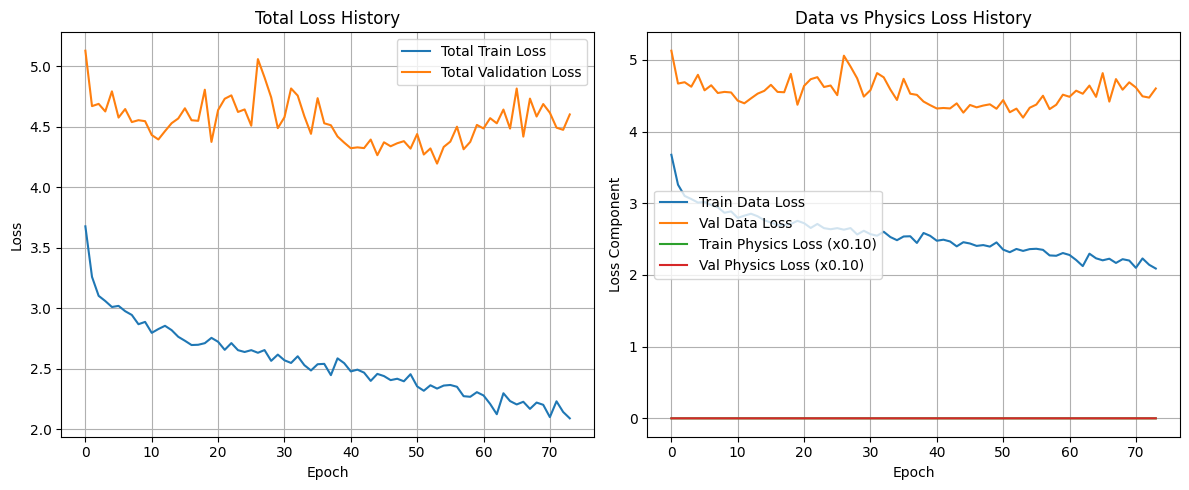

In [9]:
# Cell 9: 학습 루프 (Training Loop)

if len(df) > 0 and 'train_loader' in locals() and 'val_loader' in locals(): # 데이터 로더 존재 확인
    # Hyperparameters
    learning_rate = 0.001
    epochs = 200
    patience = 20

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping parameters
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Lists to store loss history
    train_loss_history = []
    val_loss_history = []
    train_data_loss_hist = []
    train_phys_loss_hist = []
    val_data_loss_hist = []
    val_phys_loss_hist = []

    print(f"\n--- Starting Training ---")
    print(f"Epochs: {epochs}, LR: {learning_rate}, Lambda_Physics: {lambda_physics_value}, Patience: {patience}")

    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0.0
        train_epoch_data_loss = 0.0
        train_epoch_phys_loss = 0.0

        for batch_X, batch_y_scaled, batch_E in train_loader:
            batch_X, batch_y_scaled, batch_E = batch_X.to(device), batch_y_scaled.to(device), batch_E.to(device)

            outputs_scaled = model(batch_X)
            loss, data_loss, phys_loss = pinn_loss_function(
                outputs_scaled, batch_y_scaled, batch_E, 
                scalers_y, target_cols,  # 이 부분을 scalers_y와 target_cols로 변경
                lambda_physics=lambda_physics_value, device=device
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
            train_epoch_data_loss += data_loss.item()
            # 물리 손실이 0이 아닐 때만 기록 (NaN 방지)
            train_epoch_phys_loss += phys_loss.item() if not torch.isnan(phys_loss) else 0.0


        avg_train_loss = train_epoch_loss / len(train_loader)
        avg_train_data_loss = train_epoch_data_loss / len(train_loader)
        avg_train_phys_loss = train_epoch_phys_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        train_data_loss_hist.append(avg_train_data_loss)
        train_phys_loss_hist.append(avg_train_phys_loss)

        # Validation phase
        model.eval()
        val_epoch_loss = 0.0
        val_epoch_data_loss = 0.0
        val_epoch_phys_loss = 0.0
        with torch.no_grad():
            for batch_X_val, batch_y_val_scaled, batch_E_val in val_loader:
                batch_X_val, batch_y_val_scaled, batch_E_val = batch_X_val.to(device), batch_y_val_scaled.to(device), batch_E_val.to(device)

                outputs_val_scaled = model(batch_X_val)
                val_loss, val_data_loss, val_phys_loss = pinn_loss_function(
                     outputs_val_scaled, batch_y_val_scaled, batch_E_val, 
                     scalers_y, target_cols,  # 이 부분을 scalers_y와 target_cols로 변경
                     lambda_physics=lambda_physics_value, device=device
                )
                val_epoch_loss += val_loss.item()
                val_epoch_data_loss += val_data_loss.item()
                val_epoch_phys_loss += val_phys_loss.item() if not torch.isnan(val_phys_loss) else 0.0


        avg_val_loss = val_epoch_loss / len(val_loader)
        avg_val_data_loss = val_epoch_data_loss / len(val_loader)
        avg_val_phys_loss = val_epoch_phys_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)
        val_data_loss_hist.append(avg_val_data_loss)
        val_phys_loss_hist.append(avg_val_phys_loss)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f} (Data: {avg_train_data_loss:.4f}, Phys: {avg_train_phys_loss:.4f}), "
              f"Val Loss: {avg_val_loss:.4f} (Data: {avg_val_data_loss:.4f}, Phys: {avg_val_phys_loss:.4f})")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_fatigue_pinn_model.pth')
            print(f"  Validation loss improved. Saved best model.")
        else:
            epochs_no_improve += 1
            print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            break

    print("\n--- Training Complete ---")

    # Plot loss history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Total Train Loss')
    plt.plot(val_loss_history, label='Total Validation Loss')
    plt.title('Total Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_data_loss_hist, label='Train Data Loss')
    plt.plot(val_data_loss_hist, label='Val Data Loss')
    # 물리 손실 시각화 시 lambda 곱해서 스케일 확인
    plt.plot(np.array(train_phys_loss_hist) * lambda_physics_value, label=f'Train Physics Loss (x{lambda_physics_value:.2f})')
    plt.plot(np.array(val_phys_loss_hist) * lambda_physics_value, label=f'Val Physics Loss (x{lambda_physics_value:.2f})')
    plt.title('Data vs Physics Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Component')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("\\nSkipping training loop as data is not available.")


--- 테스트 세트 평가 중 ---
epf (index 2) 역변환 (np.expm1) applied.

테스트 세트 성능 (원래 스케일):
  spf_MPa:
    MSE: 76914.3281
    R2 Score: 0.7604
  b:
    MSE: 0.0005
    R2 Score: 0.3067
  epf:
    MSE: 2.0348
    R2 Score: 0.0662
  c:
    MSE: 0.0090
    R2 Score: 0.5299

예측값 vs. 실제값 그래프 생성 중...


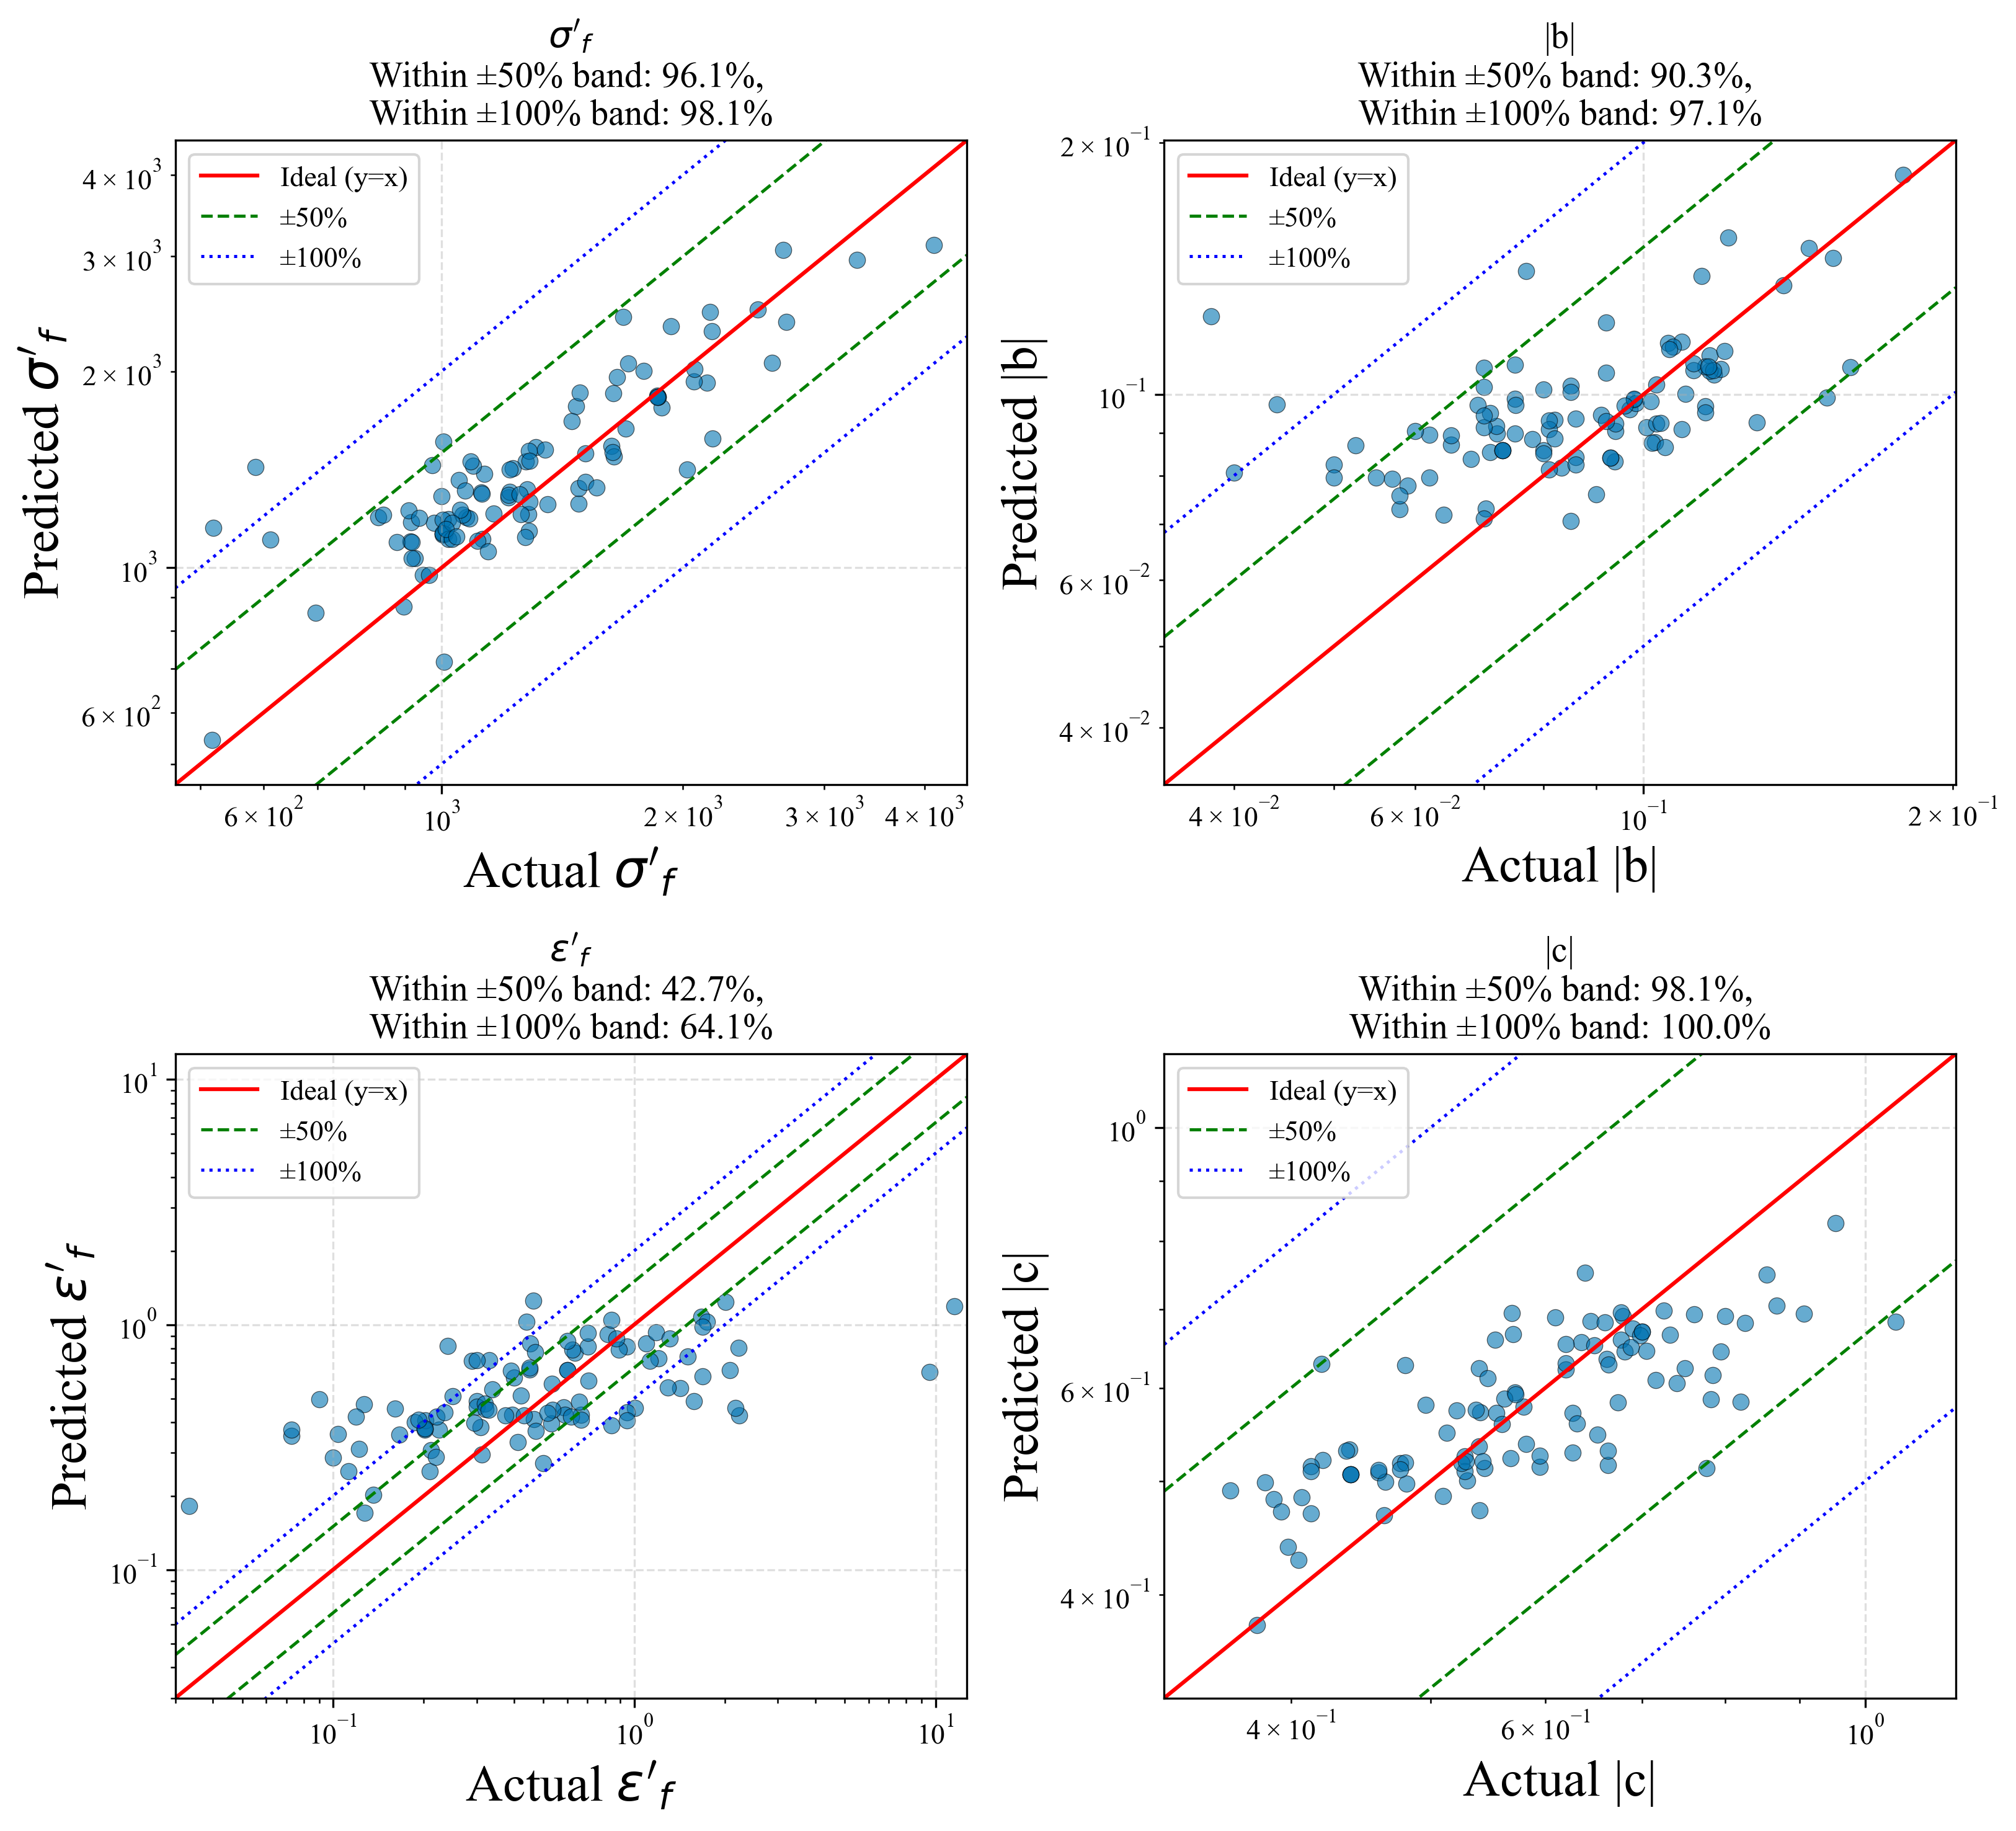

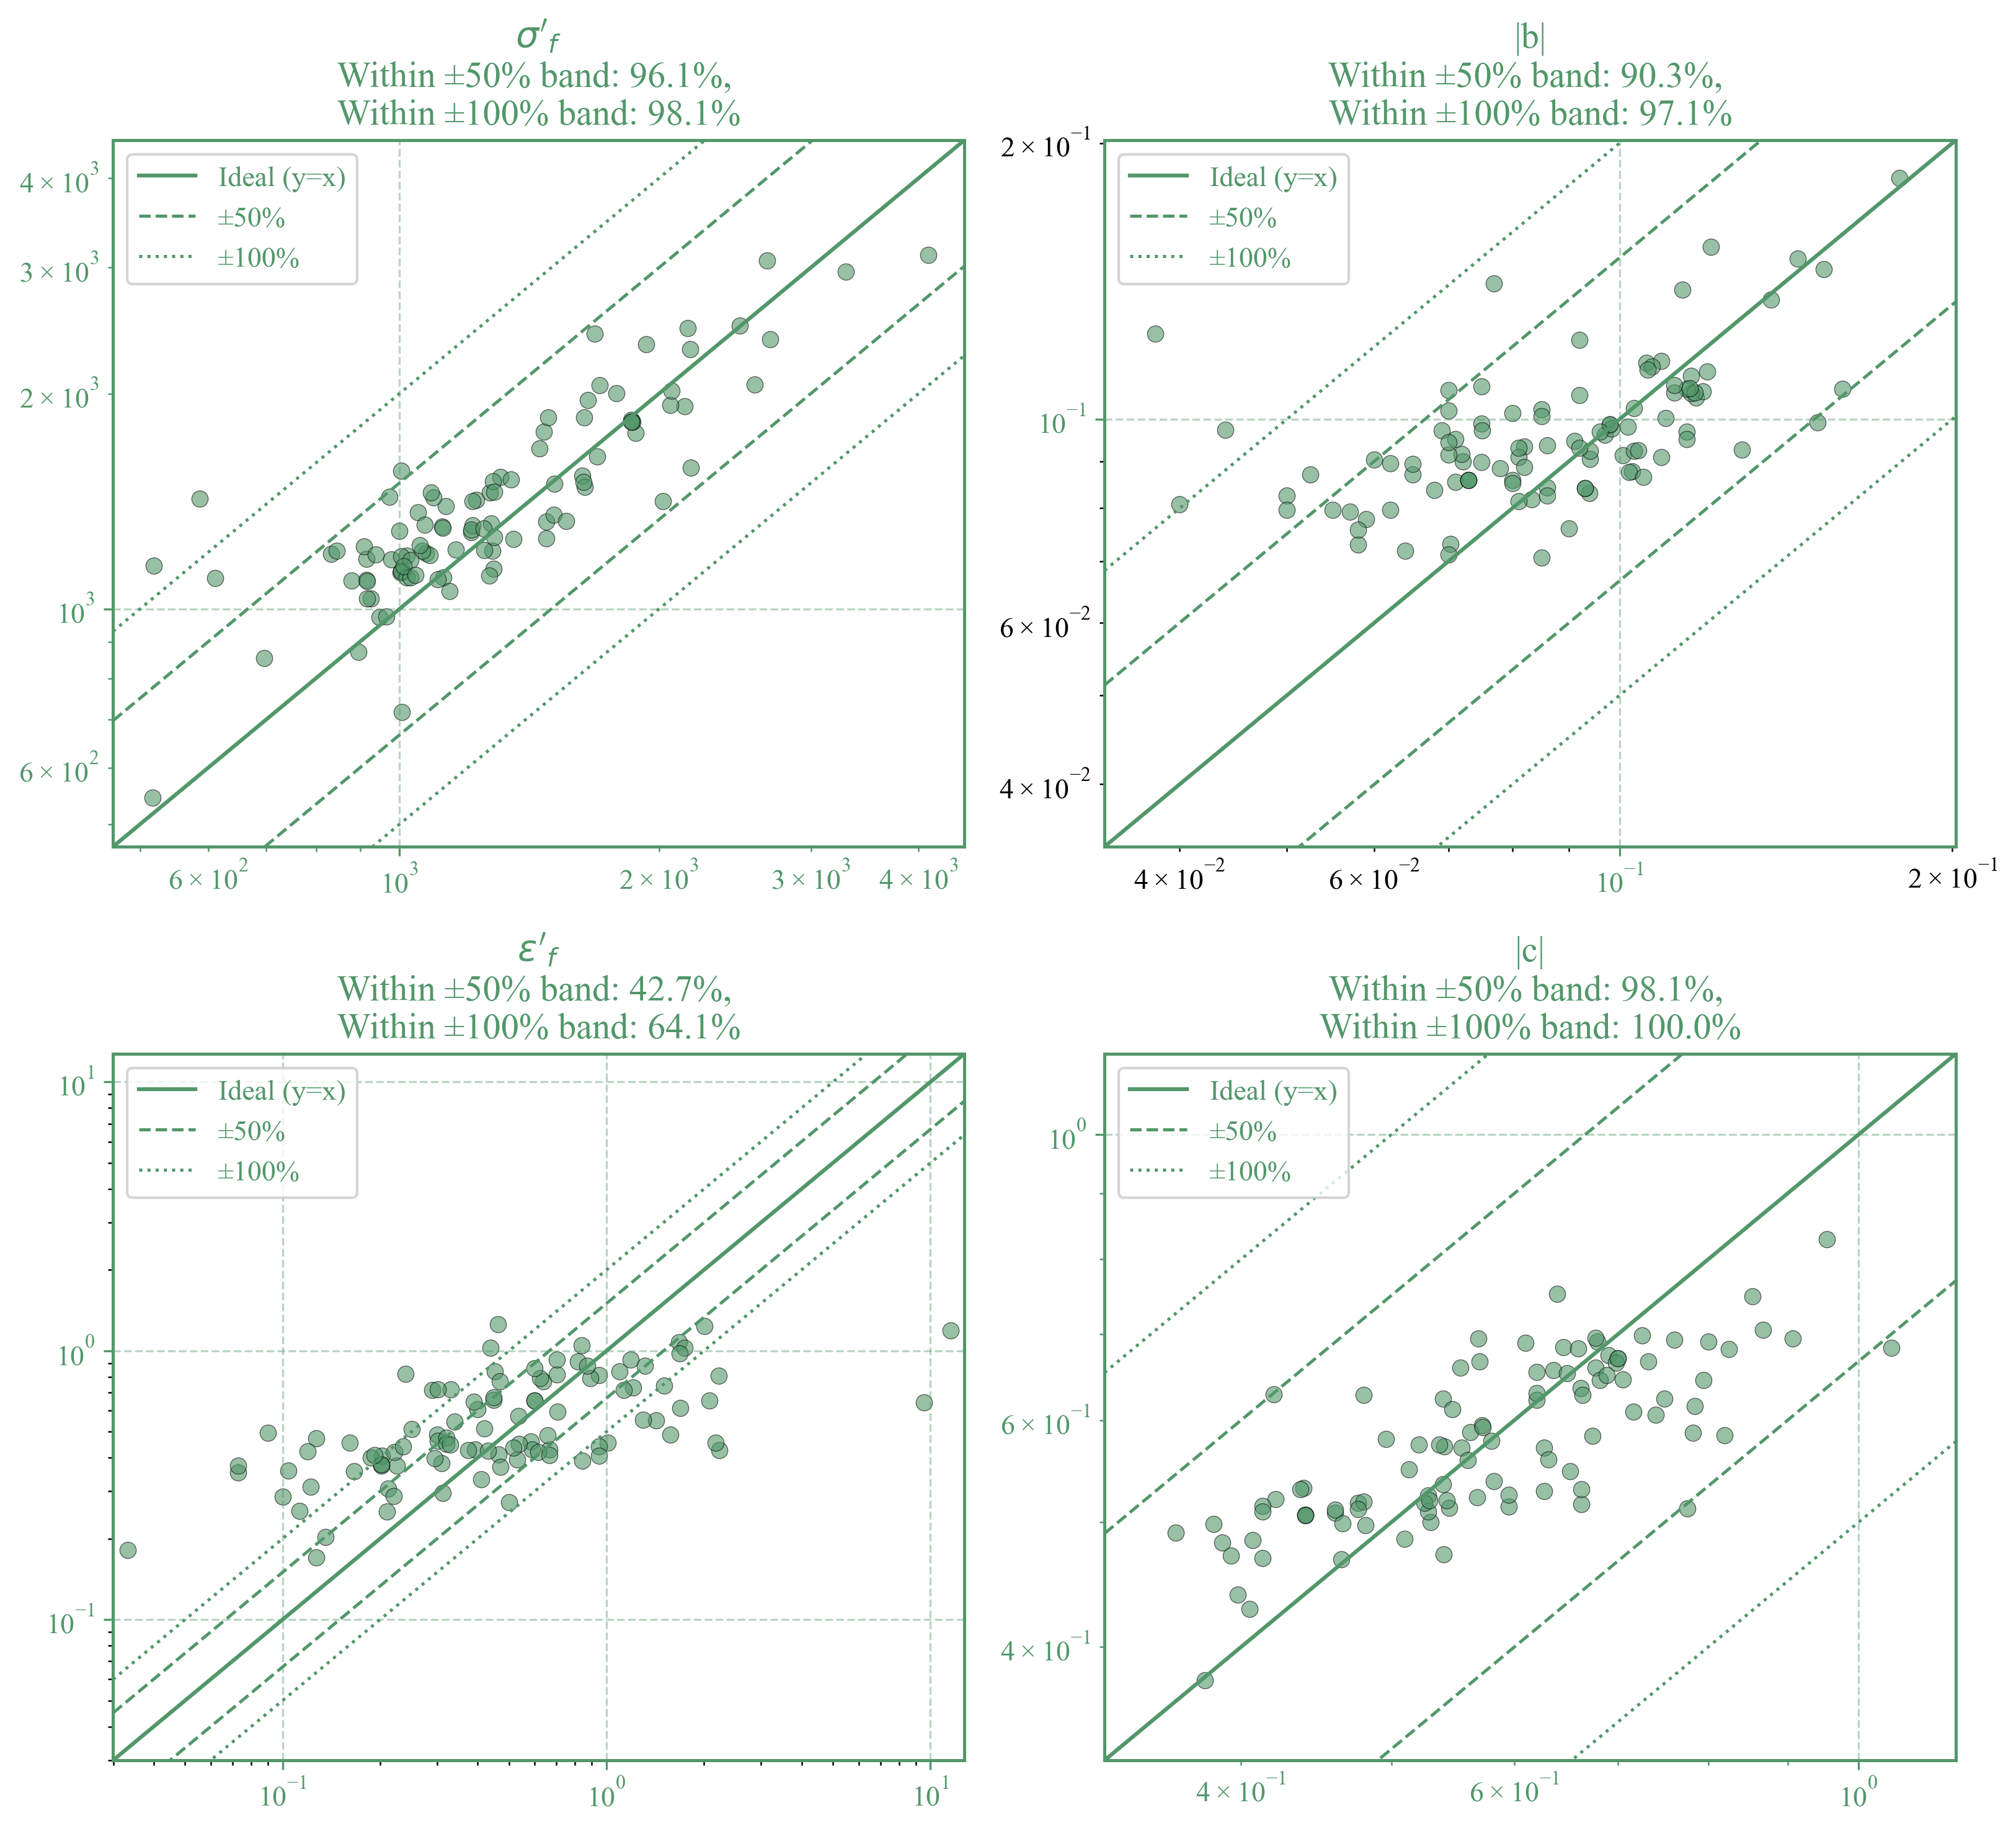

In [10]:
# Cell 10: Evaluation

# Load the best model saved during training
model.load_state_dict(torch.load('best_fatigue_pinn_model.pth', map_location=device))
model.eval() # Set to evaluation mode

all_preds_scaled = []
all_targets_scaled = []
all_targets_orig = []

print("\n--- 테스트 세트 평가 중 ---")
with torch.no_grad():
    for batch_X_test, batch_y_test_scaled, batch_E_test, batch_y_test_orig in test_loader:
        batch_X_test, batch_y_test_scaled = batch_X_test.to(device), batch_y_test_scaled.to(device)

        # Predict scaled parameters
        outputs_test_scaled = model(batch_X_test)

        all_preds_scaled.append(outputs_test_scaled.cpu().numpy())
        all_targets_scaled.append(batch_y_test_scaled.cpu().numpy())
        all_targets_orig.append(batch_y_test_orig.cpu().numpy())

# Concatenate results from all batches
all_preds_scaled = np.concatenate(all_preds_scaled, axis=0)
all_targets_scaled = np.concatenate(all_targets_scaled, axis=0)
all_targets_orig = np.concatenate(all_targets_orig, axis=0)

# Inverse transform predictions to original scale
all_preds_orig = inverse_transform_targets(all_preds_scaled, scalers_y, target_cols)

# Calculate metrics for each parameter in original scale
metrics = {}
print("\n테스트 세트 성능 (원래 스케일):")
for i, param_name in enumerate(target_cols):
    param_pred = all_preds_orig[:, i]
    param_true = all_targets_orig[:, i]

    mse = mean_squared_error(param_true, param_pred)
    r2 = r2_score(param_true, param_pred)
    metrics[param_name] = {'MSE': mse, 'R2': r2}
    print(f"  {param_name}:")
    print(f"    MSE: {mse:.4f}")
    print(f"    R2 Score: {r2:.4f}")

# Visualize Predictions vs. Actuals
print("\n예측값 vs. 실제값 그래프 생성 중...")

import matplotlib as mpl
import matplotlib.pyplot as plt

# Times New Roman 폰트 설정 및 기타 스타일 (전역적용)
mpl.rcParams.update({
    'font.family': 'serif',  # serif 계열 폰트 사용
    'font.serif': 'Times New Roman', # serif 계열 중 Times New Roman 지정
    'font.size': 12, #기본 폰트 크기
    'axes.labelsize': 20, #x,y축 레이블 폰트 크기
    'axes.titlesize': 14, #제목 폰트 크기
    'legend.fontsize': 11, #범례 폰트 크기
    'xtick.labelsize': 11, #x축 눈금 레이블 폰트 크기
    'ytick.labelsize': 11, #y축 눈금 레이블 폰트 크기
    'lines.linewidth': 1.8, #선 두께
    'axes.grid': True, #그리드 표시 여부
    'grid.alpha': 0.3, #그리드 투명도
    'figure.dpi': 300, #해상도  
    'axes.unicode_minus': False # 하이픈-마이너스 사용 (폰트 경고 방지)
})

# 색상 팔레트 선택 (Color Universal Design safe)
import seaborn as sns
palette = sns.color_palette("colorblind")  # or "muted", "Set2", "deep"

# 2x2 그리드로 변경
fig, axes = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')  # 배경 투명하게 설정
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 쉽게 접근

for i, param_name in enumerate(target_cols):
    param_pred = all_preds_orig[:, i]
    param_true = all_targets_orig[:, i]
    
    # b와 c 파라미터에 대해 절대값 사용
    if param_name == 'b' or param_name == 'c':
        param_pred = np.abs(param_pred)
        param_true = np.abs(param_true)
    
    # 오차 허용 밴드 계산 (예측값이 실제값의 ±50% 또는 ±100% 범위 내에 있는지)
    ratio = param_pred / param_true
    inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100  # ±50% 오차 범위 내 비율
    inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100     # ±100% 오차 범위 내 비율

    min_val = min(param_pred.min(), param_true.min()) * 0.9
    max_val = max(param_pred.max(), param_true.max()) * 1.1
    
    # 0이나 음수 값이 있을 경우 로그 스케일에 적합한 최소값 설정
    if min_val <= 0:
        min_val = 1e-6  # 작은 양수값으로 설정
    
    line_vals = np.linspace(min_val, max_val, 100)

    # 산점도 - R^2 legend 삭제
    axes[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=palette[0], edgecolor='k', linewidth=0.3)

    # 기준선 (y=x) 및 오차 허용 밴드
    axes[i].plot(line_vals, line_vals, 'r-', linewidth=1.5, label='Ideal (y=x)')
    
    # 1.5x error bands (±50% error)
    axes[i].plot(line_vals, line_vals * 1.5, 'g--', linewidth=1.2, label='±50%')
    axes[i].plot(line_vals, line_vals / 1.5, 'g--', linewidth=1.2)
    
    # 2x error bands (±100% error)
    axes[i].plot(line_vals, line_vals * 2.0, 'b:', linewidth=1.2, label='±100%')
    axes[i].plot(line_vals, line_vals * 0.5, 'b:', linewidth=1.2)

    # 로그 스케일 설정 (multiplicative factor가 additive offset으로 보임)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')

    # Labels and title
    if param_name == 'b' or param_name == 'c':
        axes[i].set_xlabel(f'Actual |{param_name}|')
        axes[i].set_ylabel(f'Predicted |{param_name}|')
        axes[i].set_title(f'|{param_name}|\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
    elif param_name == 'spf_MPa':
        axes[i].set_xlabel(f'Actual $\\sigma\'_f$')
        axes[i].set_ylabel(f'Predicted $\\sigma\'_f$')
        axes[i].set_title(f'$\\sigma\'_f$\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
    elif param_name == 'epf':
        axes[i].set_xlabel(f'Actual $\\varepsilon\'_f$')
        axes[i].set_ylabel(f'Predicted $\\varepsilon\'_f$')
        axes[i].set_title(f'$\\varepsilon\'_f$\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
    else:
        axes[i].set_xlabel(f'Actual {param_name}')
        axes[i].set_ylabel(f'Predicted {param_name}')
        axes[i].set_title(f'{param_name}\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
    
    axes[i].set_xlim(min_val, max_val)
    axes[i].set_ylim(min_val, max_val)
    axes[i].legend(frameon=True, loc='upper left')
    axes[i].grid(True, linestyle='--', alpha=0.4)
    axes[i].set_facecolor('none')  # 각 서브플롯 배경 투명하게 설정

plt.tight_layout()
#plt.savefig("FatifueParameters_prediction_actual.pdf", bbox_inches='tight', transparent=True)  # 투명 배경으로 PDF 저장

# 두 번째 그래프 - 지정된 색상(R82 G151 B106)으로 저장
custom_color = (82/255, 151/255, 106/255)  # RGB 값을 0-1 범위로 변환

# 새로운 그림 생성
fig2, axes2 = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')
axes2 = axes2.flatten()

for i, param_name in enumerate(target_cols):
    param_pred = all_preds_orig[:, i]
    param_true = all_targets_orig[:, i]
    
    if param_name == 'b' or param_name == 'c':
        param_pred = np.abs(param_pred)
        param_true = np.abs(param_true)
    
    ratio = param_pred / param_true
    inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100
    inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100

    min_val = min(param_pred.min(), param_true.min()) * 0.9
    max_val = max(param_pred.max(), param_true.max()) * 1.1
    
    if min_val <= 0:
        min_val = 1e-6
    
    line_vals = np.linspace(min_val, max_val, 100)

    # 산점도 추가 - R^2 legend 삭제
    axes2[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=custom_color, edgecolor='k', linewidth=0.3)

    # 모든 선을 지정된 색상으로 설정
    axes2[i].plot(line_vals, line_vals, '-', color=custom_color, linewidth=1.5, label='Ideal (y=x)')
    axes2[i].plot(line_vals, line_vals * 1.5, '--', color=custom_color, linewidth=1.2, label='±50%')
    axes2[i].plot(line_vals, line_vals / 1.5, '--', color=custom_color, linewidth=1.2)
    axes2[i].plot(line_vals, line_vals * 2.0, ':', color=custom_color, linewidth=1.2, label='±100%')
    axes2[i].plot(line_vals, line_vals * 0.5, ':', color=custom_color, linewidth=1.2)

    axes2[i].set_xscale('log')
    axes2[i].set_yscale('log')

    if param_name == 'b' or param_name == 'c':
        #axes2[i].set_xlabel(f'Actual |{param_name}|', color=custom_color)
        #axes2[i].set_ylabel(f'Predicted |{param_name}|', color=custom_color)
        axes2[i].set_title(f'|{param_name}|\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%', color=custom_color)
    elif param_name == 'spf_MPa':
        #axes2[i].set_xlabel(f'Actual $\\sigma\'_f$', color=custom_color)
        #axes2[i].set_ylabel(f'Predicted $\\sigma\'_f$', color=custom_color)
        axes2[i].set_title(f'$\\sigma\'_f$\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%', color=custom_color)
    elif param_name == 'epf':
        #axes2[i].set_xlabel(f'Actual $\\varepsilon\'_f$', color=custom_color)
        #axes2[i].set_ylabel(f'Predicted $\\varepsilon\'_f$', color=custom_color)
        axes2[i].set_title(f'$\\varepsilon\'_f$\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%', color=custom_color)
    else:
        #axes2[i].set_xlabel(f'Actual {param_name}', color=custom_color)
        #axes2[i].set_ylabel(f'Predicted {param_name}', color=custom_color)
        axes2[i].set_title(f'{param_name}\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%', color=custom_color)
    
    axes2[i].set_xlim(min_val, max_val)
    axes2[i].set_ylim(min_val, max_val)
    axes2[i].legend(frameon=True, loc='upper left', labelcolor=custom_color)
    axes2[i].grid(True, linestyle='--', alpha=0.4, color=custom_color)
    axes2[i].set_facecolor('none')
    
    # 테두리 색상을 custom_color로 변경
    for spine in axes2[i].spines.values():
        spine.set_color(custom_color)
        spine.set_linewidth(1.2)
    
    # 축 눈금 및 레이블 색상 변경
    axes2[i].tick_params(axis='both', colors=custom_color)
    
    # 로그 스케일 눈금 값들의 색상 변경 - 모든 그래프에 적용
    for label in axes2[i].get_xticklabels():
        label.set_color(custom_color)
    for label in axes2[i].get_yticklabels():
        label.set_color(custom_color)
    
    # 범례 텍스트 색상 변경
    legend = axes2[i].get_legend()
    for text in legend.get_texts():
        text.set_color(custom_color)

    # 로그 스케일 눈금 색상 변경 추가 확인 (sigma'f와 c 그래프용)
    if param_name == 'spf_MPa' or param_name == 'c':
        # 메이저 및 마이너 눈금 모두 색상 변경
        axes2[i].tick_params(axis='x', which='both', colors=custom_color)
        axes2[i].tick_params(axis='y', which='both', colors=custom_color)
        
        # 모든 눈금 레이블 색상 명시적 설정
        for label in axes2[i].xaxis.get_ticklabels(which='both'):
            label.set_color(custom_color)
        for label in axes2[i].yaxis.get_ticklabels(which='both'):
            label.set_color(custom_color)

plt.tight_layout()
#plt.savefig("FatifueParameters_prediction_actual_green.pdf", bbox_inches='tight', transparent=True)

plt.show()



--- Testing E-N and Gamma-N Curve Generation ---
Example Input (from X_test[0] using feature_cols: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed']):
  E: 221000 MPa
  YS_MPa (Index: 1): 579 MPa
  TS_MPa (Index: 2): 898 MPa
  HB_processed (Index: 3): 249.0
epf (index 2) 역변환 (np.expm1) applied.

인장 파라미터 예측 결과:
  spf_MPa: 1280.1639
  b: -0.0854
  epf: 0.4562
  c: -0.5476

전단 파라미터 예측 결과:
  tauf_MPa: 739.1030
  gammaf: 0.7901
  b0: -0.0854
  c0: -0.5476
  conversion_method: von Mises


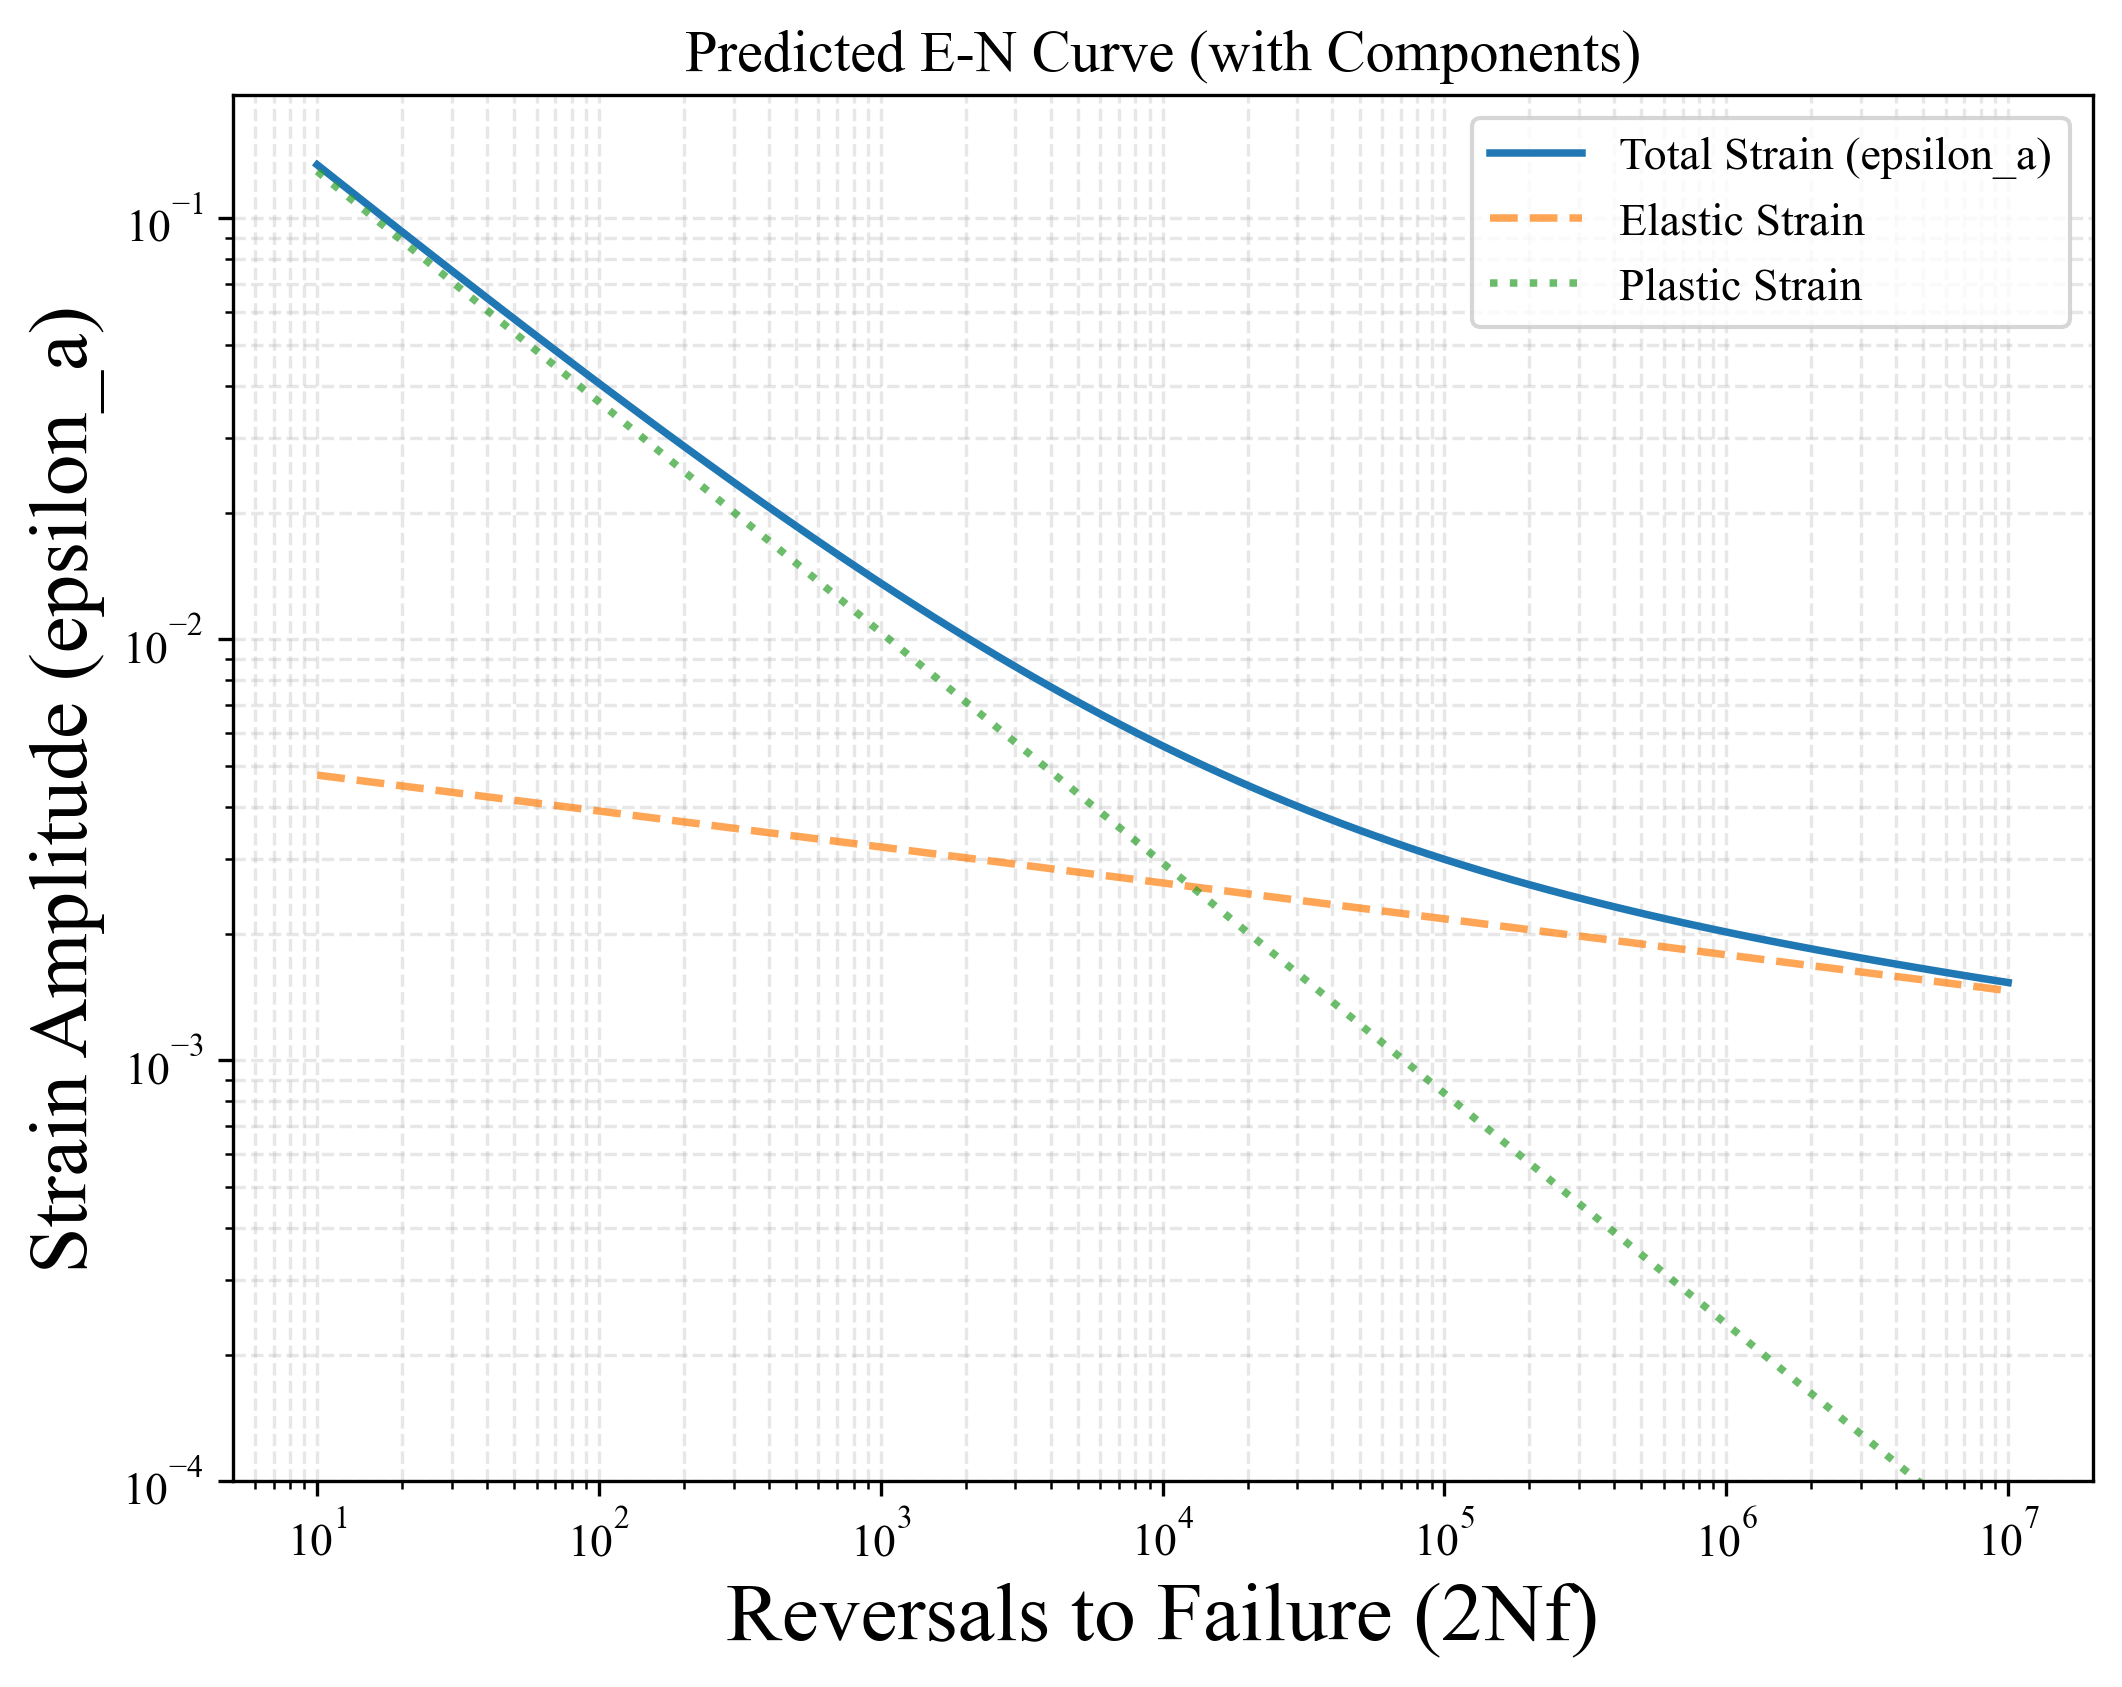

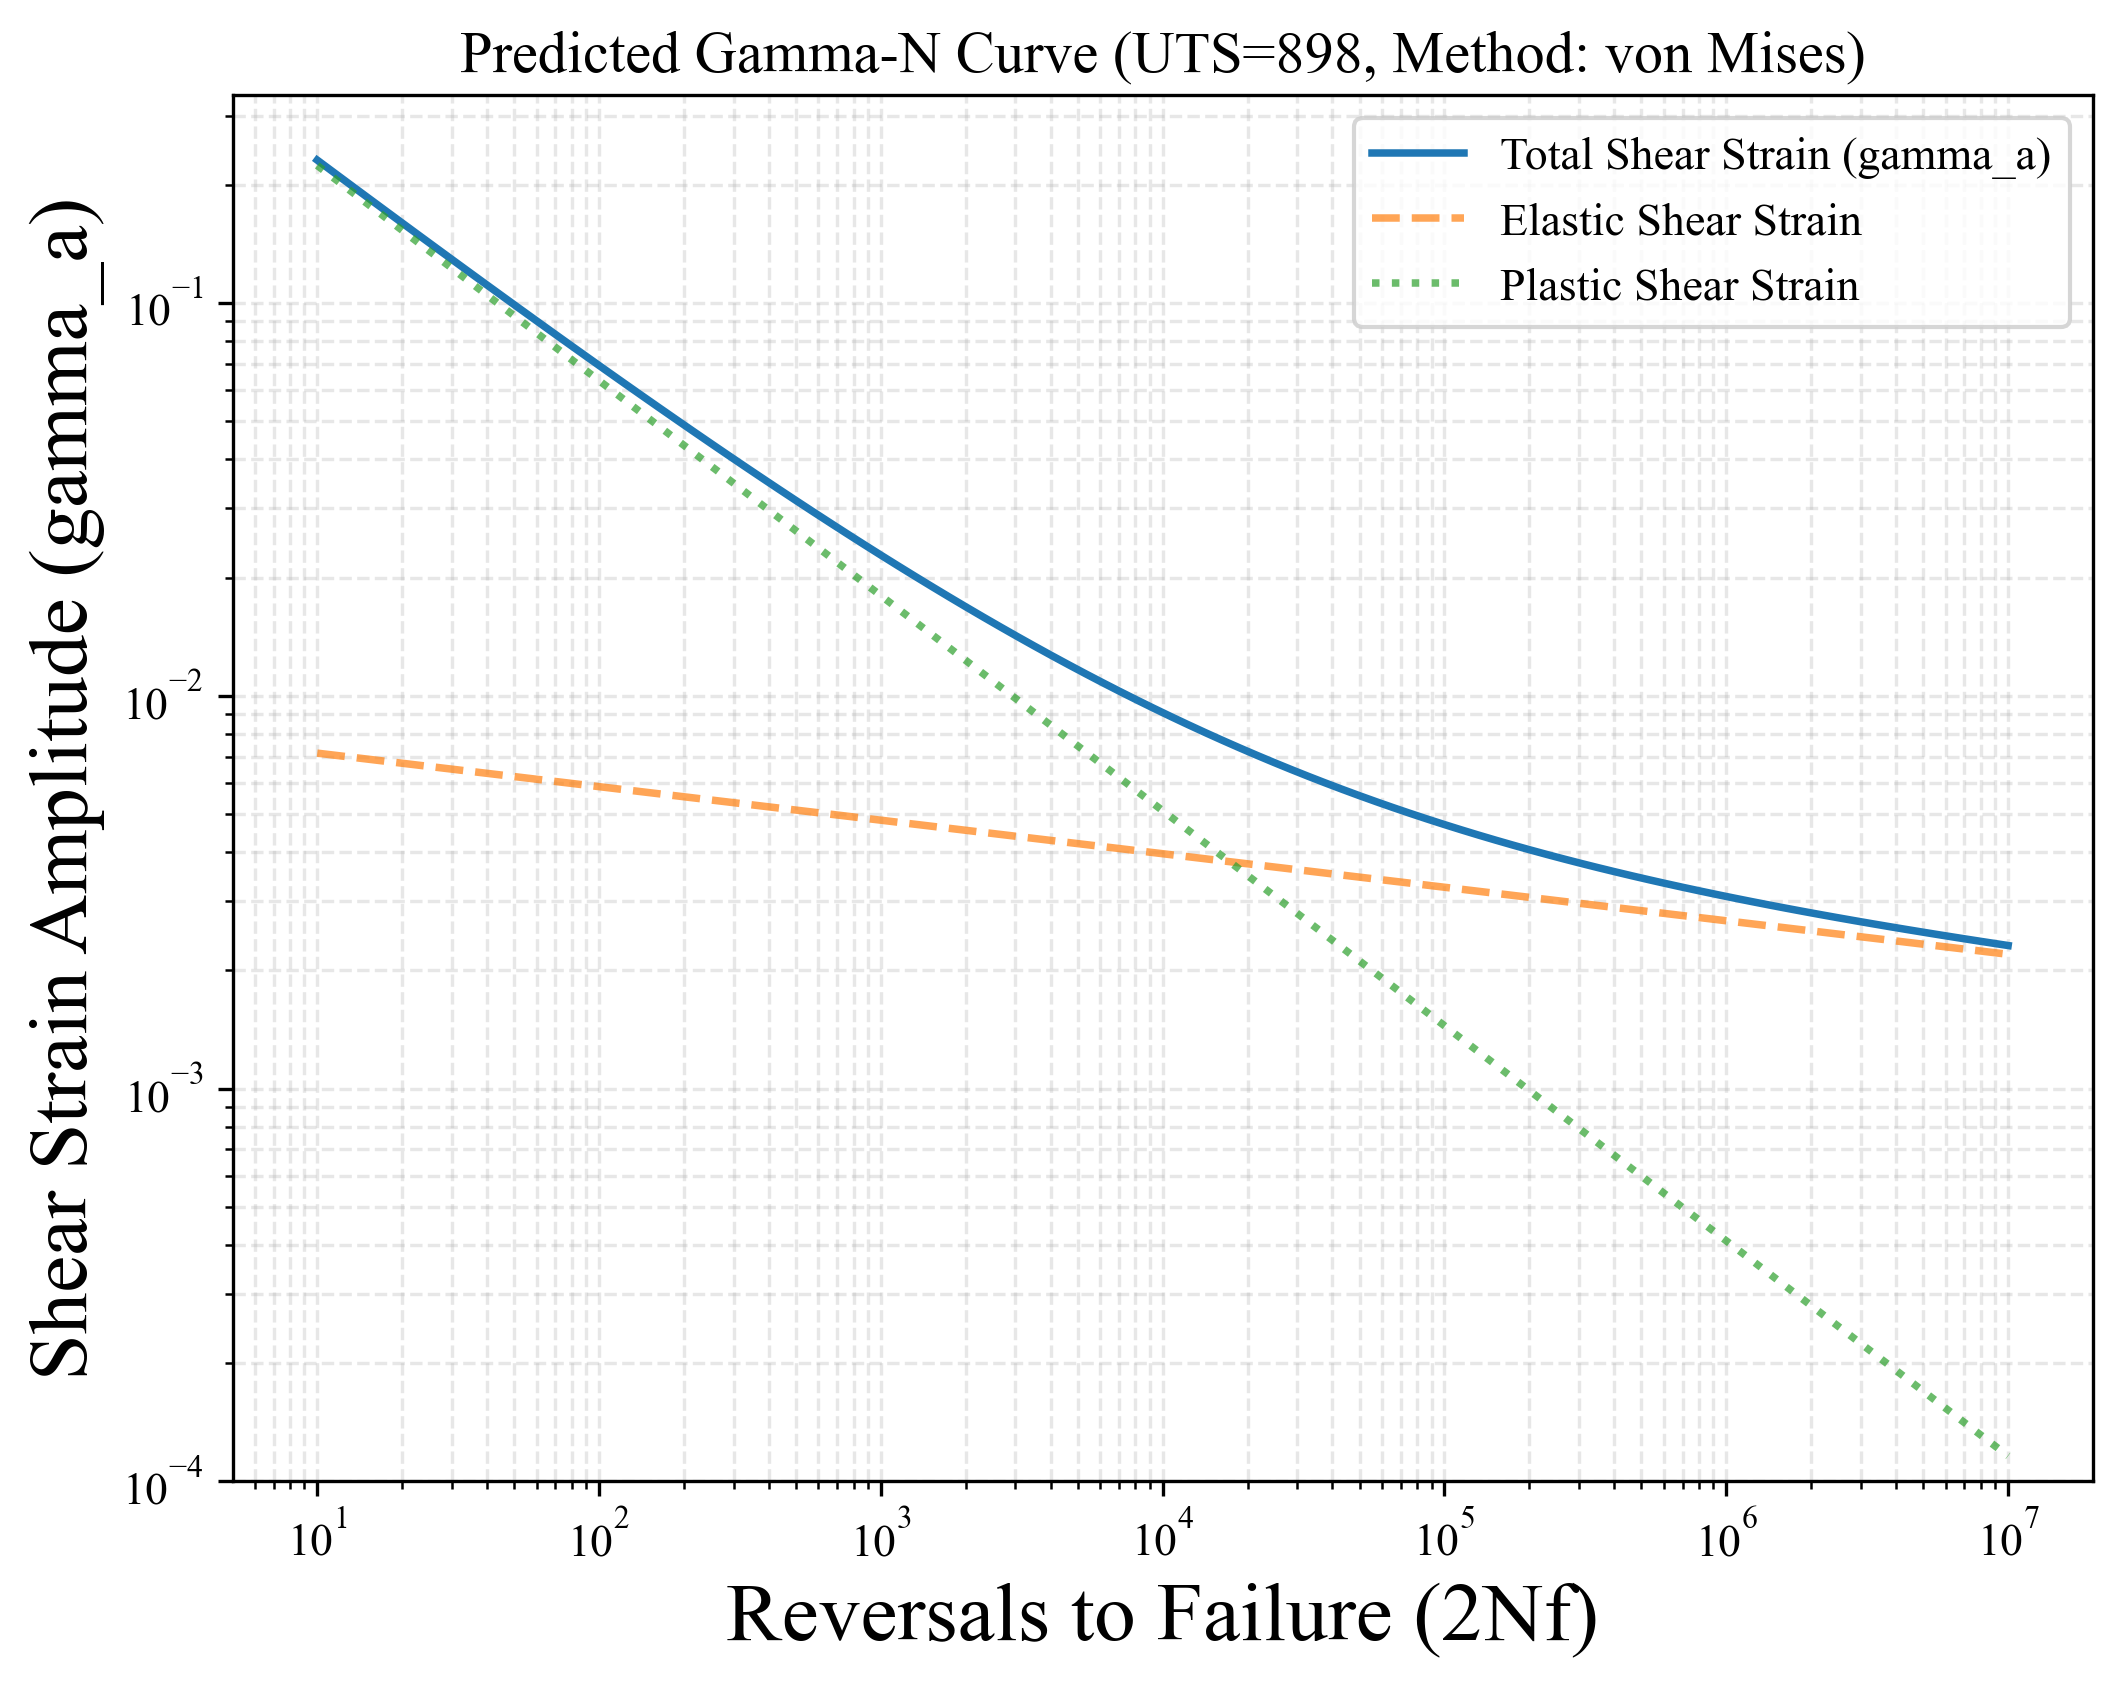

In [11]:
# Cell 11: E-N 및 Gamma-N 곡선 생성 함수 

# df 변수 확인 없이 바로 함수 정의
def predict_fatigue_curves(E_val, YS_val, TS_val, HB_val, model, scaler_X, 
                           scalers_y_dict, target_cols_list,  # 수정된 부분
                           device, mode='both', nu=0.3):
    """
    인장 파라미터를 예측하고 E-N 및 Gamma-N 곡선 데이터를 생성합니다.

    Args:
        E_val (float): 탄성 계수 (MPa)
        YS_val (float): 항복 강도 (MPa)
        TS_val (float): 인장 강도 (MPa)
        HB_val (float): 브리넬 경도 (처리된 값)
        model (torch.nn.Module): 학습된 FatiguePINN 모델
        scaler_X (StandardScaler): 입력 특성에 대한 스케일러
        scalers_y_dict (dict): 출력 파라미터별 스케일러 딕셔너리
        target_cols_list (list): 타겟 컬럼 이름 리스트
        device (str): 장치 ('cpu', 'cuda', 'mps')
        mode (str, optional): 반환 모드 ('tensile', 'shear', 'both'). 기본값은 'both'.
        nu (float, optional): 포아송 비. 기본값은 0.3.

    Returns:
        mode에 따라 다른 값을 반환합니다:
        - 'tensile': (tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain)
        - 'shear': (shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain)
        - 'both': (tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain,
                  shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain)
    """
    model.eval() # 모델을 평가 모드로 설정

    # --- 1. 인장 파라미터 예측 ---
    input_features = np.array([[E_val, YS_val, TS_val, HB_val]])
    input_scaled = scaler_X.transform(input_features)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        predicted_tensile_params_scaled = model(input_tensor)
    
    # 모델 예측 결과 역변환 부분 수정
    predicted_tensile_params_scaled_np = predicted_tensile_params_scaled.cpu().numpy()
    predicted_tensile_params_orig = inverse_transform_targets(
        predicted_tensile_params_scaled_np,
        scalers_y_dict,
        target_cols_list
    )

    try:
        # 1. tensile_params 생성 단계
        tensile_params = {name_key: p_val for name_key, p_val in zip(target_cols_list, predicted_tensile_params_orig)}

        # 2. 키 확인 단계
        required_tensile_keys = ['spf_MPa', 'b', 'epf', 'c']
        if not all(key in tensile_params for key in required_tensile_keys):
            raise ValueError(f"Missing keys in tensile_params. Required: {required_tensile_keys}, Got: {tensile_params.keys()}")

        # 3. 파라미터 추출 단계
        spf_prime = tensile_params['spf_MPa']
        b_param = tensile_params['b'] 
        epf_prime = tensile_params['epf']
        c_param = tensile_params['c'] 

        reversals = np.logspace(1, 7, num=100)
        E_val_safe = max(E_val, 1e-6)
        
        # 4. elastic_strain 계산 단계
        if not isinstance(b_param, (int, float, np.number)):
            raise TypeError("b_param for exponent must be a number.")
        elastic_strain = (spf_prime / E_val_safe) * (reversals ** b_param)
        
        # 5. plastic_strain 계산 단계
        if not isinstance(c_param, (int, float, np.number)):
             raise TypeError("c_param for exponent must be a number.")
        plastic_strain = epf_prime * (reversals ** c_param)
        
        strain_amplitude_en = elastic_strain + plastic_strain

        if mode == 'tensile':
            return tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain

        # --- 전단 파라미터 변환 ---
        tau_vm = spf_prime / np.sqrt(3)
        gamma_vm = np.sqrt(3) * epf_prime
        tau_mp = spf_prime / (1 + nu)
        gamma_mp = 2 * epf_prime

        if TS_val <= 1100:
            tauf_prime, gammaf_prime, b0, c0, conversion_method = tau_vm, gamma_vm, b_param, c_param, "von Mises"
        elif TS_val >= 1696:
            tauf_prime, gammaf_prime, b0, c0, conversion_method = tau_mp, gamma_mp, b_param, c_param, "Max Principal"
        else:
            alpha = (TS_val - 1100) / (1696 - 1100)
            tauf_prime = (1-alpha)*tau_vm + alpha*tau_mp
            gammaf_prime = (1-alpha)*gamma_vm + alpha*gamma_mp
            b0, c0, conversion_method = b_param, c_param, f"Interp VM→MP (α={alpha:.2f})"
        
        shear_params = {'tauf_MPa': tauf_prime, 'gammaf': gammaf_prime, 'b0': b0, 'c0': c0, 'conversion_method': conversion_method}
        G_val = E_val_safe / (2 * (1 + nu))
        
        if not isinstance(b0, (int, float, np.number)):
             raise TypeError("b0 for exponent must be a number.")
        if not isinstance(c0, (int, float, np.number)):
             raise TypeError("c0 for exponent must be a number.")

        elastic_shear_strain = (tauf_prime / G_val) * (reversals ** b0)
        plastic_shear_strain = gammaf_prime * (reversals ** c0)
        strain_amplitude_gn = elastic_shear_strain + plastic_shear_strain

        if mode == 'shear':
            return shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain
        
        return tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain, \
               shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain

    except TypeError as te_inner:
        # 스택 트레이스를 포함하여 출력하면 더 도움이 됩니다.
        import traceback
        print(traceback.format_exc())
        raise 
    except Exception as e_inner:
        import traceback
        print(traceback.format_exc())
        raise

# --- 함수 테스트 ---
print("\n--- Testing E-N and Gamma-N Curve Generation ---")
try:
    # feature_cols가 이전에 정의되었는지 확인 (Cell 4에서 정의됨)
    if 'feature_cols' not in locals() and 'feature_cols' not in globals():
        print("Error: 'feature_cols'가 정의되지 않았습니다. Cell 4를 먼저 실행해주세요.")
        raise NameError("'feature_cols' not defined")
        
    example_input_X_row = X_test[0]  # X_test의 첫 번째 행
    example_E_val = E_test[0]        # 해당 샘플의 E 값

    # feature_cols 리스트에서 각 특성의 정확한 인덱스를 가져옵니다.
    ys_col_name_in_features = 'YS_MPa'
    ts_col_name_in_features = 'TS_MPa'
    hb_col_name_in_features = 'HB_processed'  # 'HB'가 아닌 'HB_processed' 사용!

    ys_idx = feature_cols.index(ys_col_name_in_features)
    ts_idx = feature_cols.index(ts_col_name_in_features)
    hb_idx = feature_cols.index(hb_col_name_in_features)  # 오류 발생 지점 수정

    # 추출된 인덱스를 사용하여 값을 가져옵니다.
    example_YS_val = example_input_X_row[ys_idx]
    example_TS_val = example_input_X_row[ts_idx]
    example_HB_val = example_input_X_row[hb_idx]

    print(f"Example Input (from X_test[0] using feature_cols: {feature_cols}):")
    print(f"  E: {example_E_val:.0f} MPa")
    print(f"  {ys_col_name_in_features} (Index: {ys_idx}): {example_YS_val:.0f} MPa")
    print(f"  {ts_col_name_in_features} (Index: {ts_idx}): {example_TS_val:.0f} MPa")
    print(f"  {hb_col_name_in_features} (Index: {hb_idx}): {example_HB_val:.1f}")  # 변수명 일치

    # predict_fatigue_curves 함수 호출
    tensile_p, rev_en, strain_en, elastic_strain, plastic_strain, \
    shear_p, rev_gn, strain_gn, elastic_shear_strain, plastic_shear_strain = predict_fatigue_curves(
        example_E_val, example_YS_val, example_TS_val, example_HB_val,  # 추출된 변수 사용
        model, scaler_X, scalers_y, target_cols,  # 수정된 스케일러 및 타겟 정보 전달
        device, mode='both', nu=0.3
    )

    print("\n인장 파라미터 예측 결과:")
    for name, val in tensile_p.items(): print(f"  {name}: {val:.4f}")

    print("\n전단 파라미터 예측 결과:")
    for name, val in shear_p.items(): print(f"  {name}: {val if isinstance(val, str) else f'{val:.4f}'}")

    # E-N 곡선 플롯 (구성 요소 포함)
    plt.figure(figsize=(8, 6))
    plt.loglog(rev_en, strain_en, '-', label='Total Strain (epsilon_a)')
    plt.loglog(rev_en, elastic_strain, '--', label='Elastic Strain', alpha=0.7)
    plt.loglog(rev_en, plastic_strain, ':', label='Plastic Strain', alpha=0.7)
    plt.xlabel('Reversals to Failure (2Nf)')
    plt.ylabel('Strain Amplitude (epsilon_a)')
    plt.title('Predicted E-N Curve (with Components)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.ylim(bottom=1e-4)
    plt.show()

    # Gamma-N 곡선 플롯 (구성 요소 포함)
    plt.figure(figsize=(8, 6))
    plt.loglog(rev_gn, strain_gn, '-', label='Total Shear Strain (gamma_a)')
    plt.loglog(rev_gn, elastic_shear_strain, '--', label='Elastic Shear Strain', alpha=0.7)
    plt.loglog(rev_gn, plastic_shear_strain, ':', label='Plastic Shear Strain', alpha=0.7)
    plt.xlabel('Reversals to Failure (2Nf)')
    plt.ylabel('Shear Strain Amplitude (gamma_a)')
    plt.title(f'Predicted Gamma-N Curve (UTS={example_TS_val:.0f}, Method: {shear_p["conversion_method"]})')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.ylim(bottom=1e-4)
    plt.show()

except ValueError as ve:
    print(f"테스트 중 값 관련 오류 발생 (특성 이름 확인 필요): {ve}")  # 더 구체적인 오류 메시지
except NameError as ne:
    print(f"오류: 테스트 데이터(X_test, E_test) 또는 모델/스케일러를 사용할 수 없습니다. 이전 셀을 실행하세요. {ne}")
except IndexError:
    print("오류: 테스트 데이터가 비어 있거나 형태가 올바르지 않습니다.")
except Exception as e:
    print(f"테스트 중 오류가 발생했습니다: {e}")
